#  Data Analysis / ML Project - Risk Assessment in Credit Lending

This personal project aims to develop a predictive model for determining whether a client will default on their credit payment in the upcoming month. By leveraging a dataset that includes various client demographic and financial variables, we will explore the relationships between these factors and the likelihood of defaulting.

Through a structured approach, we will visualize and analyze the data to gain insights, preprocess it for modeling, and ultimately identify the most effective model for prediction. This project not only seeks to enhance understanding of the factors influencing credit default but also aims to provide valuable insights that can assist financial institutions in managing risk and making informed decisions.

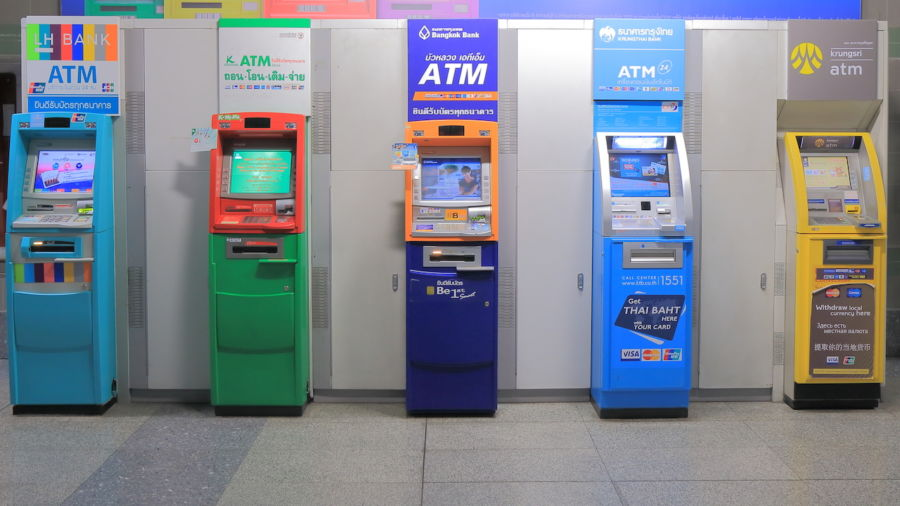

# About the Data
This dataset contains **25 variables** that provide information on clients' demographics, credit limit, payment history, and other financial data.


## Variables

- **ID**: Unique identifier for each client
- **LIMIT_BAL**: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
- **SEX**: Gender  
  - `1 = male`  
  - `2 = female`
- **EDUCATION**: Educational background  
  - `1 = graduate school`  
  - `2 = university`  
  - `3 = high school`  
  - `4 = others`  
  - `5 = unknown`  
  - `6 = unknown`
- **MARRIAGE**: Marital status  
  - `1 = married`  
  - `2 = single`  
  - `3 = others`
- **AGE**: Age in years
- **PAY_0 to PAY_6**: Repayment status (from April to September 2005)  
  - `-1 = pay duly`  
  - `1 = payment delay for one month`  
  - `2 = payment delay for two months`  
  - `...`  
  - `8 = payment delay for eight months`  
  - `9 = payment delay for nine months and above`

- **BILL_AMT1 to BILL_AMT6**: Amount of bill statement (from April to September 2005) in NT dollars
- **PAY_AMT1 to PAY_AMT6**: Amount of previous payment (from April to September 2005) in NT dollars
- **default payment next month**: Default payment indicator for the next month  
  - `1 = yes`  
  - `0 = no`


## Summary Table

| Variable                      | Description                                          | Notes                             |
| ----------------------------- | ---------------------------------------------------- | --------------------------------- |
| **ID**                        | Unique identifier                                    |                                   |
| **LIMIT_BAL**                 | Credit limit in NT dollars                           | Includes individual/family credit |
| **SEX**                       | Gender                                               | 1=Male, 2=Female                  |
| **EDUCATION**                 | Education level                                      | 1=Graduate, 2=University, etc.    |
| **MARRIAGE**                  | Marital status                                       | 1=Married, 2=Single, etc.         |
| **AGE**                       | Age in years                                         |                                   |
| **PAY_0 to PAY_6**            | Repayment status for each month                      | -1=Pay duly, 1=1-month delay, etc.|
| **BILL_AMT1 to BILL_AMT6**    | Bill amounts for each month (in NT dollars)          |                                   |
| **PAY_AMT1 to PAY_AMT6**      | Previous payments for each month (in NT dollars)     |                                   |
| **default payment next month**| Default payment for the next month (1=yes, 0=no)     |                                   |


## Loading dependencies

In [1]:
!pip install catboost
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.6 MB/s eta 0:00:00


In [111]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import time
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)




In [3]:
# Set dark background and font properties
plt.style.use('dark_background')
sns.set(style='darkgrid')
sns.set_palette('pastel')

# Set font properties
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['text.color'] = 'white'  # Set text color to white

def set_plot_style():
    # Set the overall aesthetic style of the plots
    sns.set_style('darkgrid', {'axes.facecolor': '#383838', 'figure.facecolor': '#383838'})

    # Set the context for the plots
    sns.set_context("notebook", font_scale=0.8)

    # Set color palette
    sns.set_palette('dark')

    # Adjust the default figure size
    plt.rcParams['figure.figsize'] = [8, 6]

    # Set text color for titles and labels
    plt.rcParams['axes.labelcolor'] = 'white'
    plt.rcParams['axes.titlecolor'] = 'white'
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['text.color'] = 'white'

# Call the function once
set_plot_style()

## Loading data

In [6]:
def load_and_clean_data(file_path):
    """
    Load the dataset from an Excel file and clean specific columns.

    Args:
    file_path (str): The file path of the Excel file.

    Returns:
    pd.DataFrame: The cleaned dataframe.
    """
    # Load the dataset, using the first column (ID) as the index and skipping the first row
    df = pd.read_excel(file_path, index_col=0, skiprows=1)
    #Renaming columns with more significant names
    df.rename(columns = {'PAY_0':'PAY_1', 'default payment next month':'Default'}, inplace = True)
    # Data Cleaning: Fix the 'MARRIAGE' column, replacing '0' with '3' (others)
    df['MARRIAGE'] = np.where(df['MARRIAGE'] == 0, 3, df['MARRIAGE'])

    # Data Cleaning: Fix the 'EDUCATION' column, replacing '5', '6', and '0' with '4' (others)
    df['EDUCATION'] = np.where(df['EDUCATION'].isin([0, 5, 6]), 4, df['EDUCATION'])

    return df

df = load_and_clean_data('default of credit card clients.xls')

# Display the first 5 rows of the cleaned dataset to verify the changes
df.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Understand the Data

## General Analysis

In [7]:
# Display the shape of the dataset (rows, columns)
print("Dataset shape:", df.shape)

Dataset shape: (30000, 24)


In [8]:
# Display basic info on the dataset (columns, data types, and missing values)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_1      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   30000 

In [9]:
#All of our data is of type integer => using describe to extract some number proprities
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.842267,1.557267,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.744494,0.521405,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


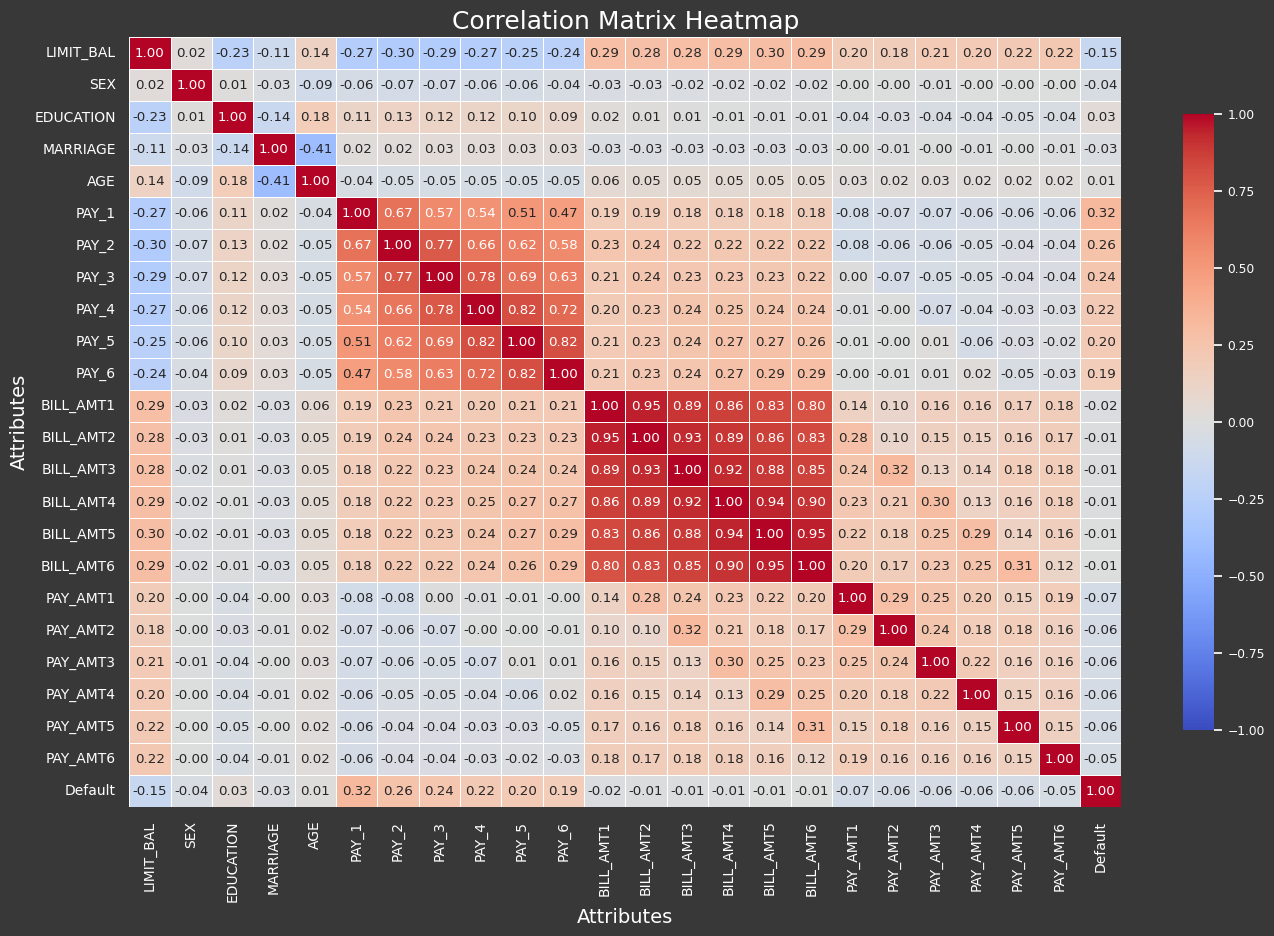

In [10]:
correlation_matrix = df.corr()

plt.figure(figsize=(16, 10), facecolor='#383838')

sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            square=False,
            linewidths=0.5,
            cbar_kws={"shrink": .8},
            vmin=-1, vmax=1)

plt.gcf().set_facecolor('#383838')

plt.title('Correlation Matrix Heatmap', fontsize=18, color='white')
plt.xlabel('Attributes', fontsize=14, color='white')
plt.ylabel('Attributes', fontsize=14, color='white')

plt.xticks(color='white', fontsize=10)
plt.yticks(color='white', fontsize=10)

plt.show()


Here are some key insights derived from the Correlation Matrix:

1. **Payment History**:
   - Strong positive correlations exist among payment variables (PAY_0 to PAY_6). For instance, PAY_2 and PAY_3 have a significant correlation of 0.767, indicating consistent payment behavior over time.

2. **Age and Default Risk**:
   - A strong negative correlation of -0.418 between age and default risk suggests that older individuals are less likely to default, potentially indicating greater financial stability with age.

3. **Limit Balance Impact**:
   - The correlation between limit balance and default risk shows a negative correlation of -0.451. Higher credit limits appear to correlate with a lower risk of default.

4. **Bill Amounts**:
   - Bill amounts (BILL_AMT1 to BILL_AMT6) are highly correlated with each other, particularly BILL_AMT1 with BILL_AMT2 (0.951). This consistent trend in billing can aid in modeling future payment behaviors.

## Targeted Analysis

### Default Payement

In [11]:
df.Default.value_counts()

,count
Default,
0,23364
1,6636


 <br />The research paper mentionned that we have **25000** line of data and we have **30000** => therefore 16.66% of our data is dirty <br />
The dataset is unbalanced, with 23,364 entries (78%) labeled as 0 (no default) and 6,636 entries (22%) labeled as 1 (default). This imbalance may affect the model's performance and should be addressed during analysis.




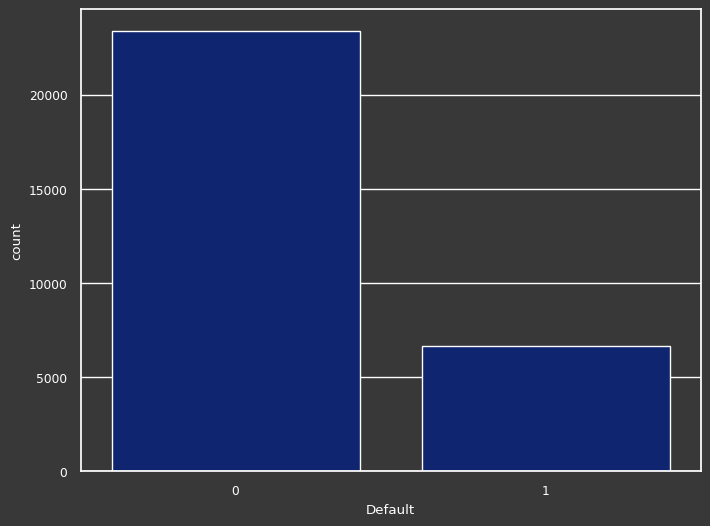

In [12]:
sns.countplot(x='Default', data=df)
plt.show()

### Age

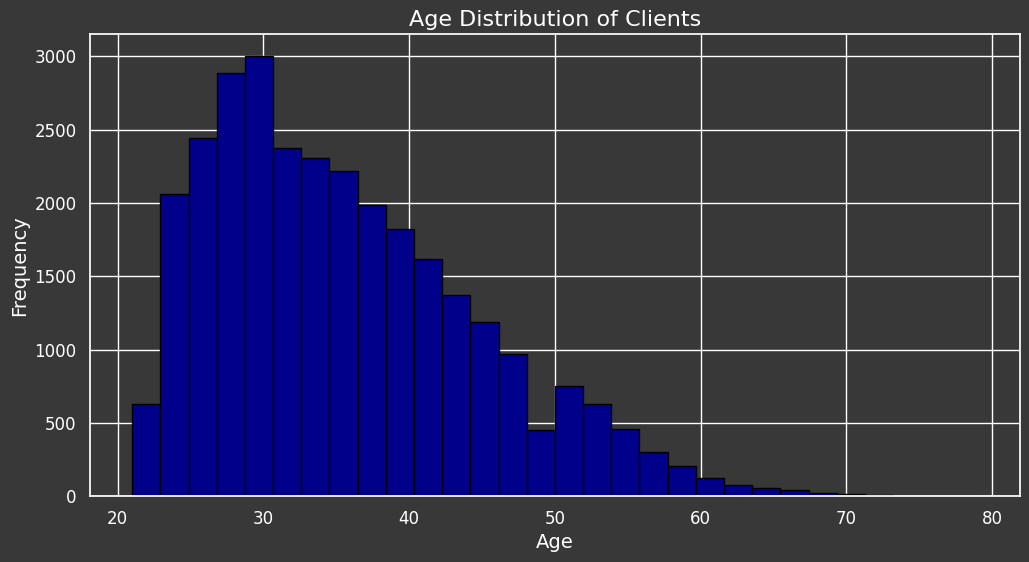

In [13]:
plt.figure(figsize=(12, 6))
df['AGE'].hist(bins=30, color='darkblue', edgecolor='black')

plt.title('Age Distribution of Clients', fontsize=16, color='white')
plt.xlabel('Age', fontsize=14, color='white')
plt.ylabel('Frequency', fontsize=14, color='white')
plt.xticks(color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)
plt.gcf().set_facecolor('#383838')

plt.show()

Clients within the age barcket of [20..40] are a majority


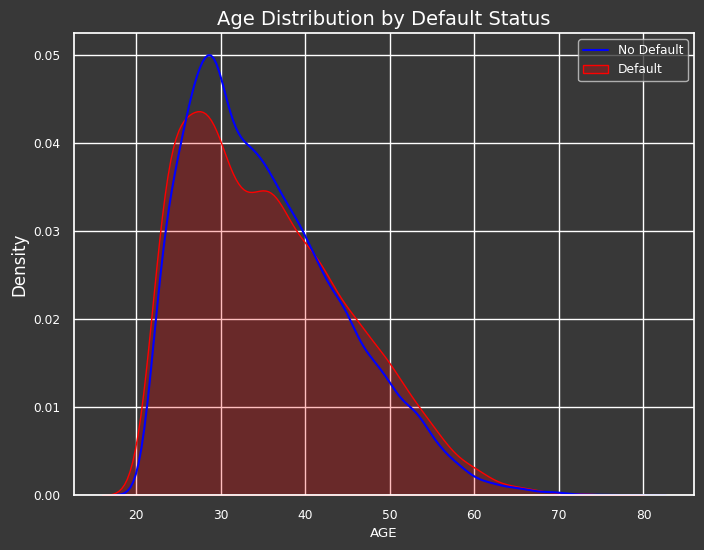

In [14]:
plt.figure()

# Plot KDE for No Default with a specific color
sns.kdeplot(df.loc[df['Default'] == 0, 'AGE'], label='No Default', fill=False, color='blue')

# Plot KDE for Default with a different color
sns.kdeplot(df.loc[df['Default'] == 1, 'AGE'], label='Default', fill=True, color='red')

plt.ylabel('Density', fontsize=12, color='white')  # Adding ylabel for clarity
plt.title('Age Distribution by Default Status', fontsize=14, color='white')  # Adding title for clarity
plt.legend()
plt.show()


The space bitween No default and Default curves indicates that customers that are in the age barcket of [25..40] are more likely to have no default payment next month

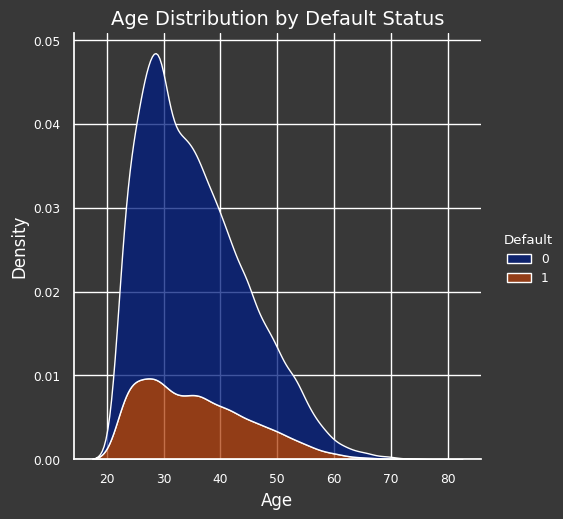

In [15]:
# Ensure the 'Default' column is a categorical type
df['Default'] = df['Default'].astype('category')

# KDE Plot using displot
sns.displot(df, x="AGE", hue="Default", kind="kde", multiple="stack", palette='dark')

plt.title('Age Distribution by Default Status', fontsize=14, color='white')
plt.xlabel('Age', fontsize=12, color='white')
plt.ylabel('Density', fontsize=12, color='white')
plt.show()

In [16]:
dfAge = df
dfAge['AgeBin'] = pd.cut(df['AGE'],[20, 25, 30, 35, 40, 50, 60, 80])
print(dfAge['AgeBin'].value_counts())

AgeBin
(25, 30]    7142
(40, 50]    6005
(30, 35]    5796
(35, 40]    4917
(20, 25]    3871
(50, 60]    1997
(60, 80]     272
Name: count, dtype: int64


In [17]:
dfAge['Default'].groupby(dfAge['AgeBin']).value_counts(normalize = True)


AgeBin    Default
(20, 25]  0          0.733402
          1          0.266598
(25, 30]  0          0.798516
          1          0.201484
(30, 35]  0          0.805728
          1          0.194272
(35, 40]  0          0.783811
          1          0.216189
(40, 50]  0          0.767027
          1          0.232973
(50, 60]  0          0.747621
          1          0.252379
(60, 80]  0          0.731618
          1          0.268382
Name: proportion, dtype: float64

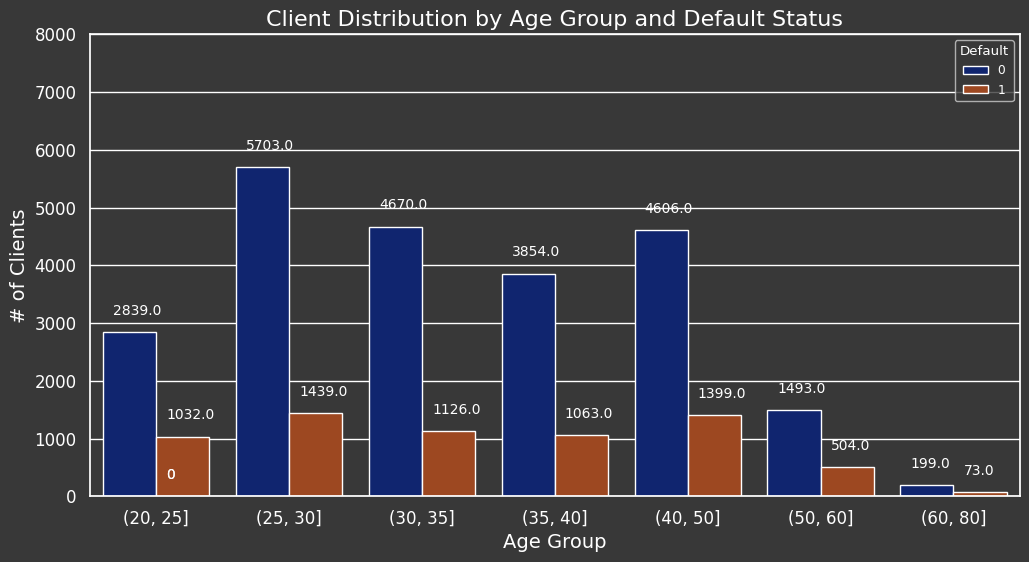

In [18]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Convert 'AgeBin' to string type
dfAge['AgeBin'] = dfAge['AgeBin'].astype('str')
AgeBin_order = ['(20, 25]', '(25, 30]', '(30, 35]', '(35, 40]', '(40, 50]', '(50, 60]', '(60, 80]']

# Create the count plot
ax = sns.countplot(data=dfAge, x='AgeBin', hue="Default", palette='dark', order=AgeBin_order)

# Set labels and title
plt.xlabel("Age Group", fontsize=14, color='white')
plt.ylabel("# of Clients", fontsize=14, color='white')
plt.title("Client Distribution by Age Group and Default Status", fontsize=16, color='white')

# Set y-axis limit
plt.ylim(0, 8000)

# Annotate the bars with the counts
for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x() + 0.075, p.get_height() + 300),
                fontsize=10, color='white')

# Customize tick labels
plt.xticks(color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)

# Set the background color of the figure
plt.gcf().set_facecolor('#383838')

# Show the plot
plt.show()

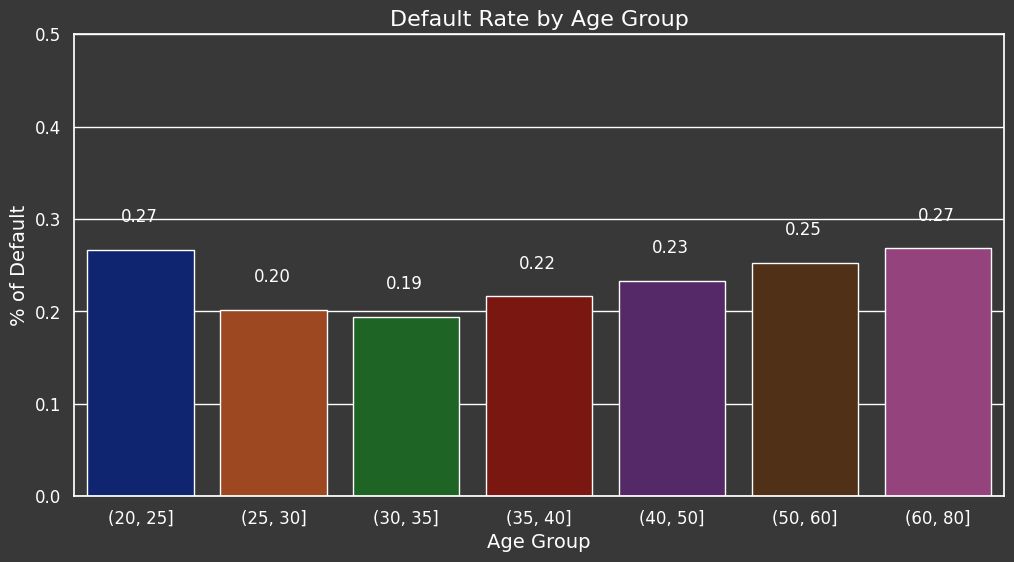

In [19]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(x="AgeBin", y="Default", data=dfAge, palette='dark', ci=None, order=AgeBin_order)

plt.xlabel("Age Group", fontsize=14, color='white')
plt.ylabel("% of Default", fontsize=14, color='white')
plt.ylim(0, 0.5)
plt.title("Default Rate by Age Group", fontsize=16, color='white')

for p in ax.patches:
    ax.annotate("%.2f" % (p.get_height()), (p.get_x() + 0.25, p.get_height() + 0.03), fontsize=12, color='white')

plt.xticks(color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)
plt.gcf().set_facecolor('#383838')

plt.show()


As expected, the lowest chances of default are registered around 30-35 years old, while the highest occur at the extremes (20-25 and 60+).



### Marital Status

In [20]:
# (1=married, 2=single, 3=others)
df['MARRIAGE'].value_counts()

,count
MARRIAGE,
2,15964
1,13659
3,377


In [21]:
df['Default'].groupby(df['MARRIAGE']).value_counts(normalize = True)


MARRIAGE  Default
1         0          0.765283
          1          0.234717
2         0          0.790717
          1          0.209283
3         0          0.763926
          1          0.236074
Name: proportion, dtype: float64

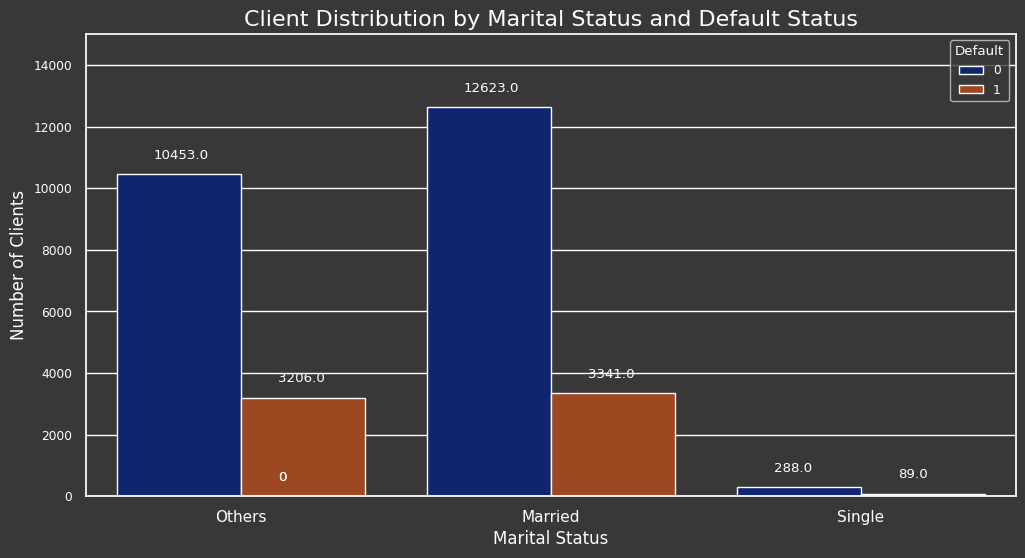

In [22]:
df = load_and_clean_data('default of credit card clients.xls')
plt.figure(figsize=(12, 6))

ax = sns.countplot(data=df, x='MARRIAGE', hue="Default", palette='dark')

plt.xlabel("Marital Status", fontsize=12)
plt.ylabel("Number of Clients", fontsize=12)
plt.ylim(0, 15000)
plt.xticks([0, 1, 2], ['Others', 'Married', 'Single'], fontsize=11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x() + 0.12, p.get_height() + 500))

plt.title("Client Distribution by Marital Status and Default Status", fontsize=16)
plt.show()


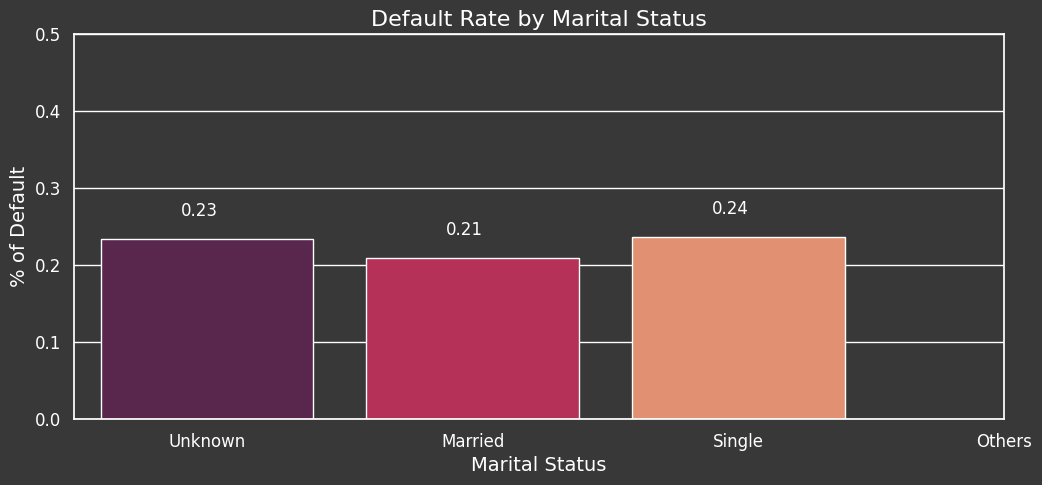

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

ax = sns.barplot(x="MARRIAGE", y="Default", data=df, palette='rocket', ci=None)

plt.xlabel("Marital Status", fontsize=14, color='white')
plt.ylabel("% of Default", fontsize=14, color='white')
plt.ylim(0, 0.5)
plt.xticks([0, 1, 2, 3], ['Unknown', 'Married', 'Single', 'Others'], fontsize=12, color='white')
plt.title("Default Rate by Marital Status", fontsize=16, color='white')

for p in ax.patches:
    ax.annotate("%.2f" % (p.get_height()), (p.get_x() + 0.30, p.get_height() + 0.03), fontsize=12, color='white')

plt.yticks(color='white', fontsize=12)
plt.gcf().set_facecolor('#383838')

plt.show()


Analyse

### Sex

In [24]:
df.SEX.value_counts()

,count
SEX,
2,18112
1,11888


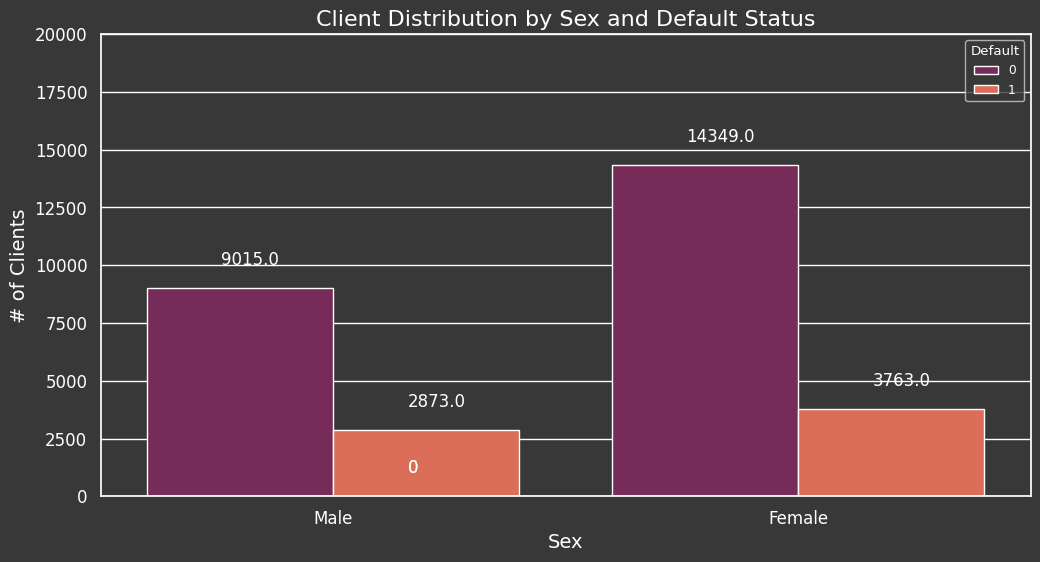

In [25]:
plt.figure(figsize=(12, 6))

ax = sns.countplot(data=df, x='SEX', hue="Default", palette='rocket')

plt.xlabel("Sex", fontsize=14, color='white')
plt.ylabel("# of Clients", fontsize=14, color='white')
plt.ylim(0, 20000)
plt.xticks([0, 1], ['Male', 'Female'], fontsize=12, color='white')
plt.title("Client Distribution by Sex and Default Status", fontsize=16, color='white')

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x() + 0.16, p.get_height() + 1000), fontsize=12, color='white')

plt.yticks(color='white', fontsize=12)
plt.gcf().set_facecolor('#383838')

plt.show()

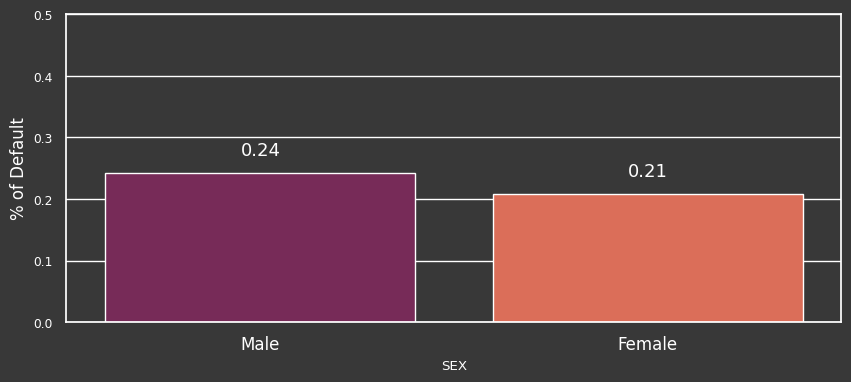

In [26]:
plt.figure(figsize=(10,4))

ax = sns.barplot(x = "SEX", y = "Default", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)
plt.xticks([0,1],['Male', 'Female'], fontsize = 12)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.35, p.get_height()+0.03),fontsize=13)

plt.show()

There are more women than men in our dataset and, apparently, men have a slightly higher chance of default. We will try to confirm it a little later by comparing men and women with the same education and marital status.



### Education

As we saw on the descriptive statistics (df.describe), there is a minimum value of 0 in 'Education', which didn't match the possible values for this feature according to the original dataset information. The additional information puts 4 values (0, 4, 5, 6) in the same category ('others').

The values '5' and '6' are both originally labelled as 'unknown' and we don't have a defined label for '0'. Maybe we can put them all together in the same category. But first, we will leave it as it is for now and check how many samples there are in each category and what is their percentage of Default.

In [27]:
df.EDUCATION.value_counts()

,count
EDUCATION,
2,14030
1,10585
3,4917
4,468


In [28]:
df['Default'].groupby(df['EDUCATION']).value_counts(normalize = True)


EDUCATION  Default
1          0          0.807652
           1          0.192348
2          0          0.762651
           1          0.237349
3          0          0.748424
           1          0.251576
4          0          0.929487
           1          0.070513
Name: proportion, dtype: float64

In [29]:
df.loc[:,'EDUCATION'] = df.loc[:,'EDUCATION'].replace(0,5)
df.loc[:,'EDUCATION'] = df.loc[:,'EDUCATION'].replace(6,5)

In [30]:
df.EDUCATION.value_counts()

,count
EDUCATION,
2,14030
1,10585
3,4917
4,468


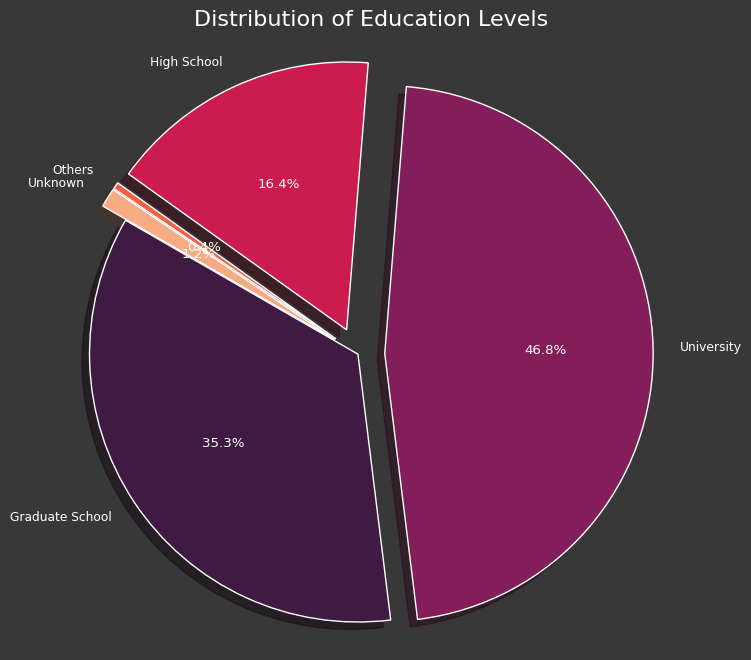

In [31]:
counts_left = [10585, 14030, 4917, 123, 345]
department_left = ['Graduate School', 'University', 'High School', 'Others', 'Unknown']
explode = [0, 0.1, 0.1, 0.1, 0.1]

fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(counts_left, explode=explode, labels=department_left, autopct='%1.1f%%',
         shadow=True, startangle=150, colors=sns.color_palette('rocket', len(counts_left)))

ax1.axis('equal')
plt.title("Distribution of Education Levels", fontsize=16, color='white')
plt.gcf().set_facecolor('#383838')

plt.show()


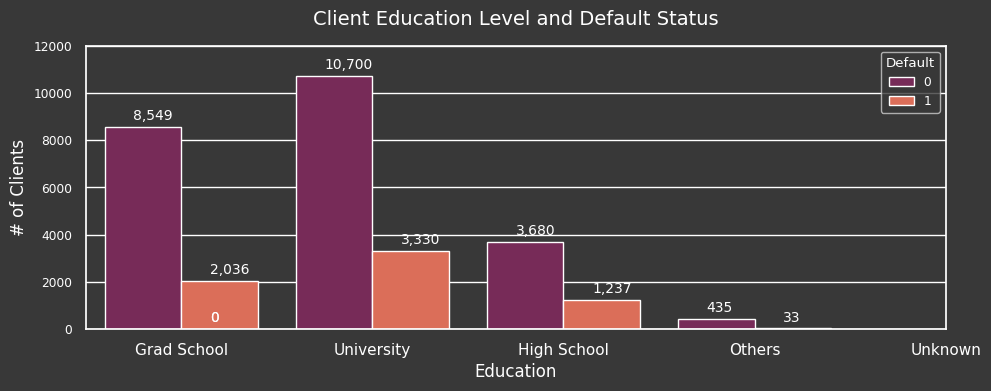

In [32]:
plt.figure(figsize=(10,4))

ax = sns.countplot(data=df, x='EDUCATION', hue="Default", palette='rocket')

plt.title("Client Education Level and Default Status", fontsize=14, pad=15)  # Added title
plt.xlabel("Education", fontsize=12)
plt.ylabel("# of Clients", fontsize=12)
plt.ylim(0,12000)
plt.xticks([0,1,2,3,4], ['Grad School', 'University', 'High School', 'Others', 'Unknown'], fontsize=11)

# Add annotations
for p in ax.patches:
    ax.annotate(f"{p.get_height():,.0f}", (p.get_x() + 0.15, p.get_height() + 300), fontsize=10)

plt.tight_layout()
plt.show()


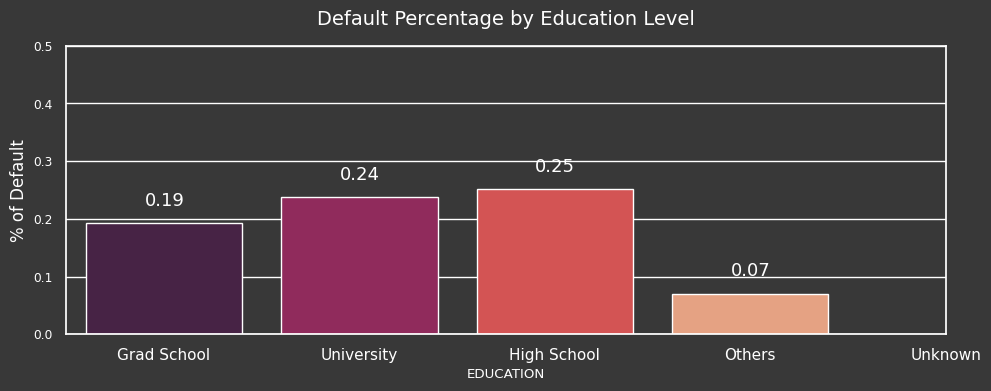

In [33]:
plt.figure(figsize=(10,4))

ax = sns.barplot(x="EDUCATION", y="Default", data=df, palette='rocket', ci=None)

plt.title("Default Percentage by Education Level", fontsize=14, pad=15)  # Added title
plt.ylabel("% of Default", fontsize=12)
plt.ylim(0, 0.5)
plt.xticks([0, 1, 2, 3, 4], ['Grad School', 'University', 'High School', 'Others', 'Unknown'], fontsize=11)

# Add annotations
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + 0.30, p.get_height() + 0.03), fontsize=13)

plt.tight_layout()
plt.show()

The predominant level of education in our dataset is 'University', followed by 'Grad School', 'High School', 'Unknown' and 'Others'.

Considering only the first three levels, it seems that a higher education translates to a lower chance of default. However, both 'Unknown' and 'Others' (which we would presume that it means a lower level than high school), have a noticeably lower probability.

### Sex + Education/Marital Status


In [34]:
df.groupby(by=['MARRIAGE', 'SEX'])['Default'].value_counts(normalize = True)


MARRIAGE  SEX  Default
1         1    0          0.740655
               1          0.259345
          2    0          0.780375
               1          0.219625
2         1    0          0.773386
               1          0.226614
          2    0          0.802784
               1          0.197216
3         1    0          0.710345
               1          0.289655
          2    0          0.797414
               1          0.202586
Name: proportion, dtype: float64

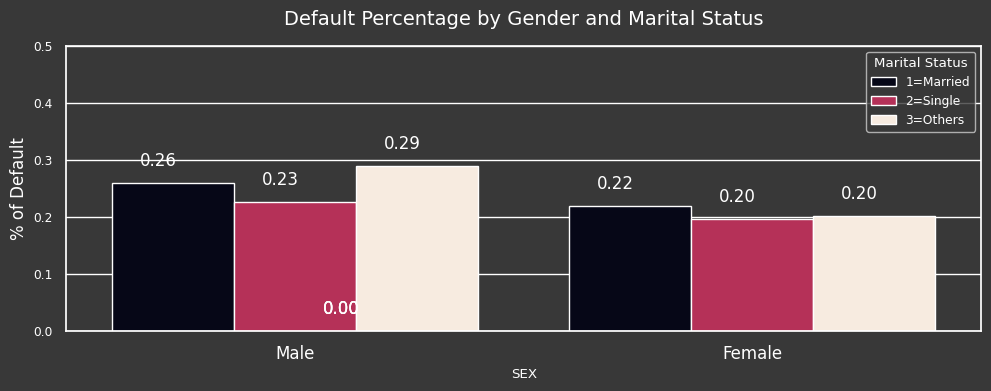

In [35]:
plt.figure(figsize=(10,4))

ax = sns.barplot(x="SEX", y="Default", hue="MARRIAGE", data=df, palette='rocket', ci=None)

plt.title("Default Percentage by Gender and Marital Status", fontsize=14, pad=15)
plt.ylabel("% of Default", fontsize=12)
plt.ylim(0, 0.5)
plt.xticks([0, 1], ['Male', 'Female'], fontsize=12)

# Update the legend labels to indicate the meaning of 1, 2, 3 for 'MARRIAGE'
marriage_labels = ['1=Married', '2=Single', '3=Others']
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=marriage_labels, title="Marital Status")

# Add annotations
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + 0.06, p.get_height() + 0.03), fontsize=12)

plt.tight_layout()
plt.show()


In [36]:
df.groupby(by=['EDUCATION', 'SEX'])['Default'].value_counts(normalize = True)


EDUCATION  SEX  Default
1          1    0          0.791915
                1          0.208085
           2    0          0.818649
                1          0.181351
2          1    0          0.737998
                1          0.262002
           2    0          0.777957
                1          0.222043
3          1    0          0.726131
                1          0.273869
           2    0          0.763580
                1          0.236420
4          1    0          0.917647
                1          0.082353
           2    0          0.936242
                1          0.063758
Name: proportion, dtype: float64

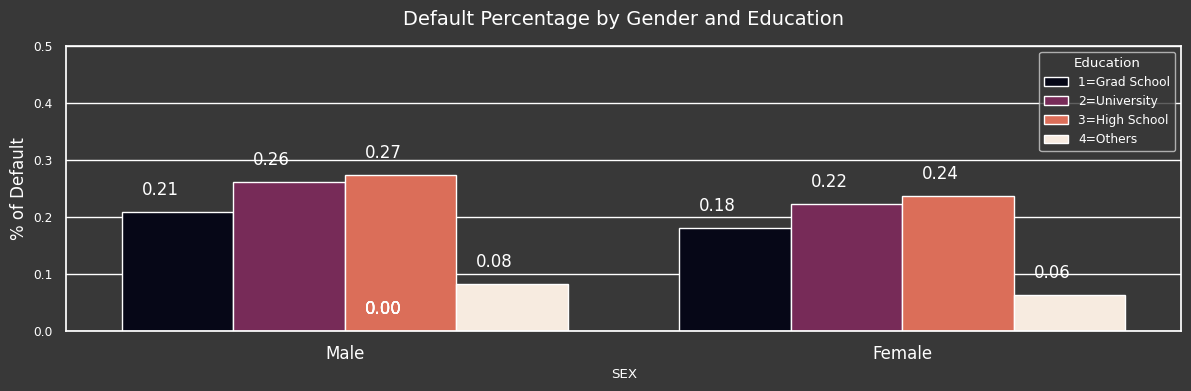

In [37]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x="SEX", y="Default", hue="EDUCATION", data=df, palette='rocket', ci=None)

plt.title("Default Percentage by Gender and Education", fontsize=14, pad=15)
plt.ylabel("% of Default", fontsize=12)
plt.ylim(0, 0.5)
plt.xticks([0, 1], ['Male', 'Female'], fontsize=12)

# Update the legend labels to indicate the meaning of the education levels
education_labels = ['1=Grad School', '2=University', '3=High School', '4=Others']
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=education_labels, title="Education")

# Add annotations
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + 0.035, p.get_height() + 0.03), fontsize=12)

plt.tight_layout()
plt.show()


In every single comparison, the probability of default was higher for men.



### Amount of Given Credit (LIMIT_BAL)


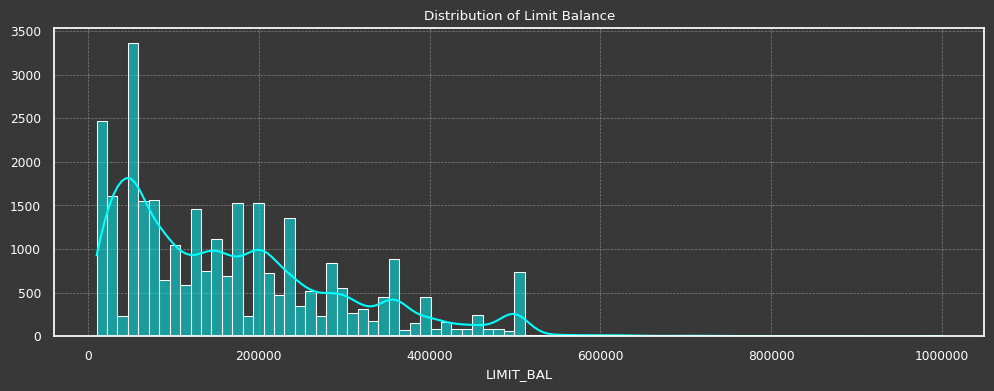

In [38]:
plt.figure(figsize=(12, 4))
sns.histplot(df['LIMIT_BAL'], kde=True, color='cyan')

plt.ticklabel_format(style='plain', axis='x')
plt.ylabel('')
plt.title('Distribution of Limit Balance', color='white')
plt.xlabel('LIMIT_BAL', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.show()

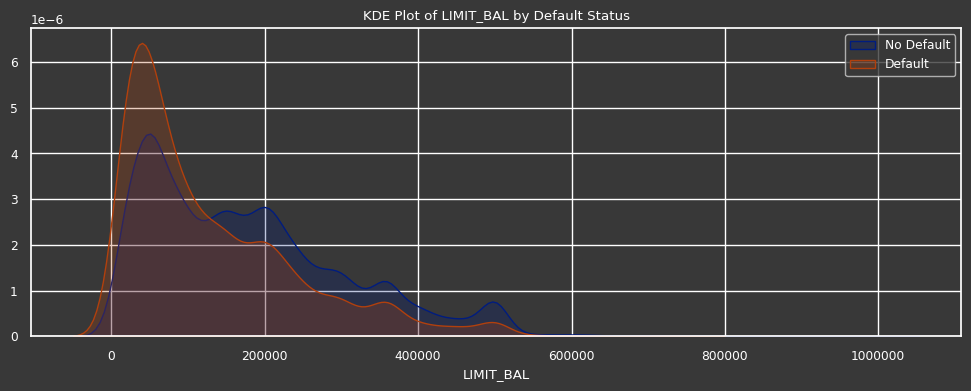

In [39]:
plt.figure(figsize=(12, 4))

sns.kdeplot(df.loc[(df['Default'] == 0), 'LIMIT_BAL'], label='No Default', shade=True)
sns.kdeplot(df.loc[(df['Default'] == 1), 'LIMIT_BAL'], label='Default', shade=True)

plt.ticklabel_format(style='plain', axis='x')
plt.ylabel('')
plt.title('KDE Plot of LIMIT_BAL by Default Status')
plt.legend()
plt.show()


In [40]:
df['LimitBin'] = pd.cut(df['LIMIT_BAL'],[5000, 50000, 100000, 150000, 200000, 300000, 400000, 500000, 1100000])
print(df['LimitBin'].value_counts())

LimitBin
(5000, 50000]        7676
(200000, 300000]     5059
(50000, 100000]      4822
(150000, 200000]     3978
(100000, 150000]     3902
(300000, 400000]     2759
(400000, 500000]     1598
(500000, 1100000]     206
Name: count, dtype: int64


In [41]:
df['Default'].groupby(df['LimitBin']).value_counts(normalize = True)

LimitBin           Default
(5000, 50000]      0          0.682126
                   1          0.317874
(50000, 100000]    0          0.742016
                   1          0.257984
(100000, 150000]   0          0.788570
                   1          0.211430
(150000, 200000]   0          0.821518
                   1          0.178482
(200000, 300000]   0          0.839494
                   1          0.160506
(300000, 400000]   0          0.859369
                   1          0.140631
(400000, 500000]   0          0.878598
                   1          0.121402
(500000, 1100000]  0          0.888350
                   1          0.111650
Name: proportion, dtype: float64

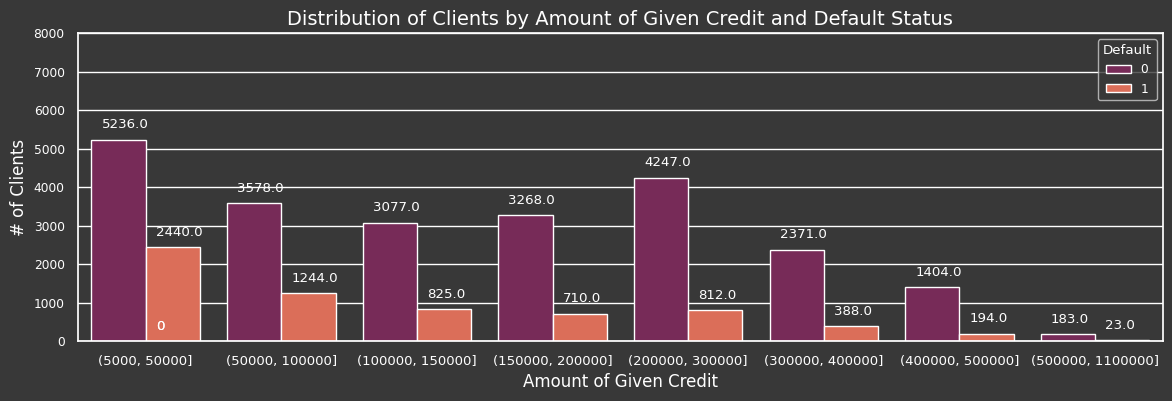

In [42]:
plt.figure(figsize=(14, 4))

df['LimitBin'] = df['LimitBin'].astype('str')
LimitBin_order = ['(5000, 50000]', '(50000, 100000]', '(100000, 150000]', '(150000, 200000]',
                  '(200000, 300000]', '(300000, 400000]', '(400000, 500000]', '(500000, 1100000]']

ax = sns.countplot(data=df, x='LimitBin', hue="Default", palette='rocket', order=LimitBin_order)

plt.title('Distribution of Clients by Amount of Given Credit and Default Status', fontsize=14)
plt.xlabel("Amount of Given Credit", fontsize=12)
plt.ylabel("# of Clients", fontsize=12)
plt.ylim(0, 8000)
ax.tick_params(axis="x", labelsize=9.5)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x() + 0.075, p.get_height() + 300))

plt.show()


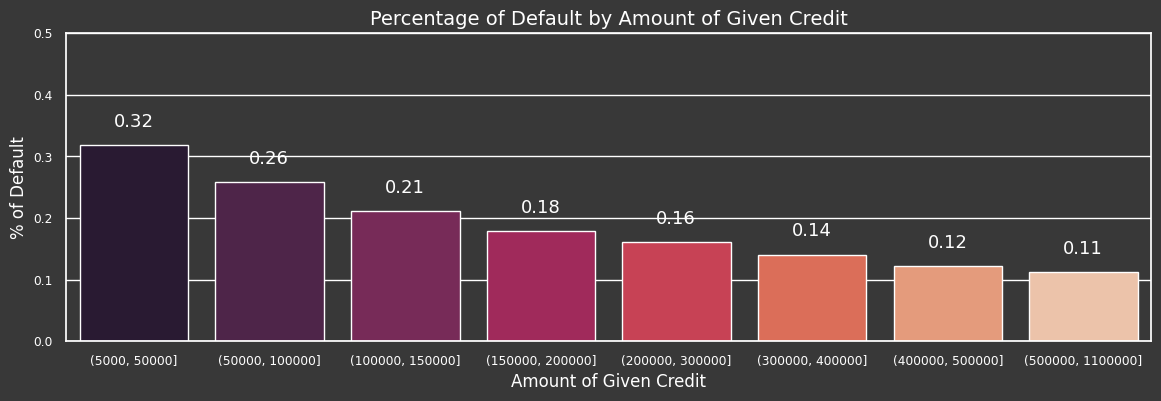

In [43]:
plt.figure(figsize=(14, 4))

ax = sns.barplot(x="LimitBin", y="Default", data=df, palette='rocket', ci=None, order=LimitBin_order)

plt.title('Percentage of Default by Amount of Given Credit', fontsize=14)
plt.xlabel("Amount of Given Credit", fontsize=12)
plt.ylabel("% of Default", fontsize=12)
plt.ylim(0, 0.5)

for p in ax.patches:
    ax.annotate("%.2f" % (p.get_height()), (p.get_x() + 0.25, p.get_height() + 0.03), fontsize=13)

plt.show()


Now it's pretty clear that there is a significant rate of default (over 30%) from customers with 50k or less of credit limit. We also can see that the higher the limit, the lower is the chance of defaulting.

### Amount of Given Credit + Demographic Features

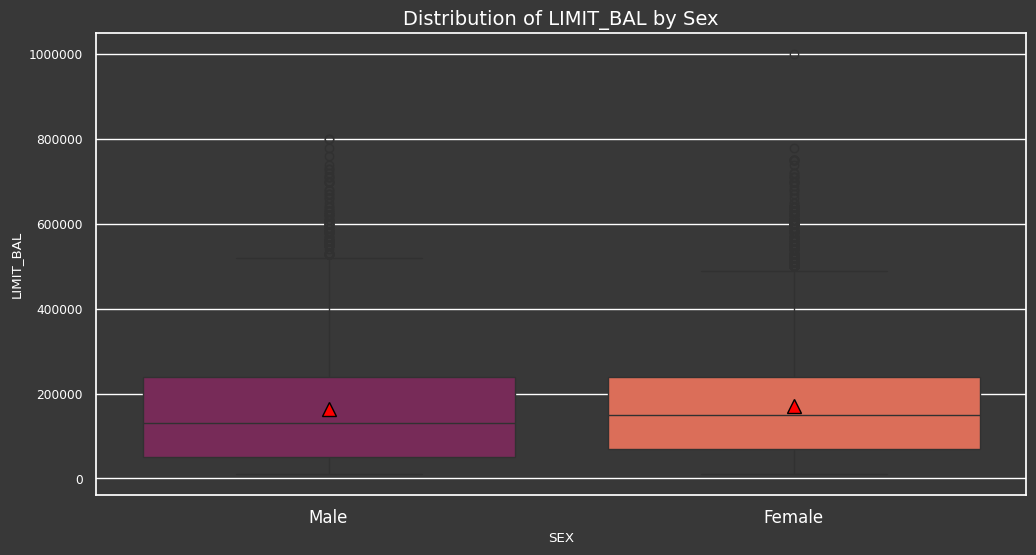

In [44]:
plt.figure(figsize=(12, 6))

sns.boxplot(x="SEX", y="LIMIT_BAL", data=df, palette='rocket', showmeans=True,
            meanprops={"markerfacecolor": "red", "markeredgecolor": "black", "markersize": "10"})

plt.title('Distribution of LIMIT_BAL by Sex', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks([0, 1], ['Male', 'Female'], fontsize=12)

plt.show()


In [45]:
df.groupby('EDUCATION')['LIMIT_BAL'].mean()

,LIMIT_BAL
EDUCATION,
1,212956.069910
2,147062.437634
3,126550.270490
4,181316.239316


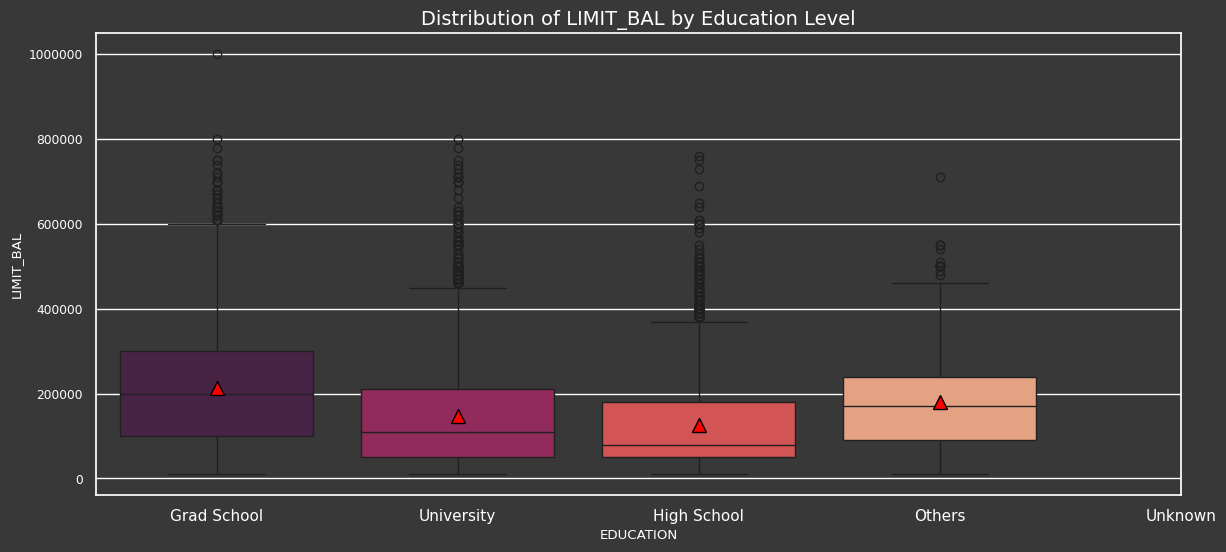

In [46]:
plt.figure(figsize=(14, 6))

sns.boxplot(x="EDUCATION", y="LIMIT_BAL", data=df, palette='rocket', showmeans=True,
            meanprops={"markerfacecolor": "red", "markeredgecolor": "black", "markersize": "10"})

plt.title('Distribution of LIMIT_BAL by Education Level', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks([0, 1, 2, 3, 4], ['Grad School', 'University', 'High School', 'Others', 'Unknown'], fontsize=11)

plt.show()


In [47]:
df.groupby('MARRIAGE')['LIMIT_BAL'].mean()


,LIMIT_BAL
MARRIAGE,
1,182200.893184
2,156413.660737
3,103076.923077


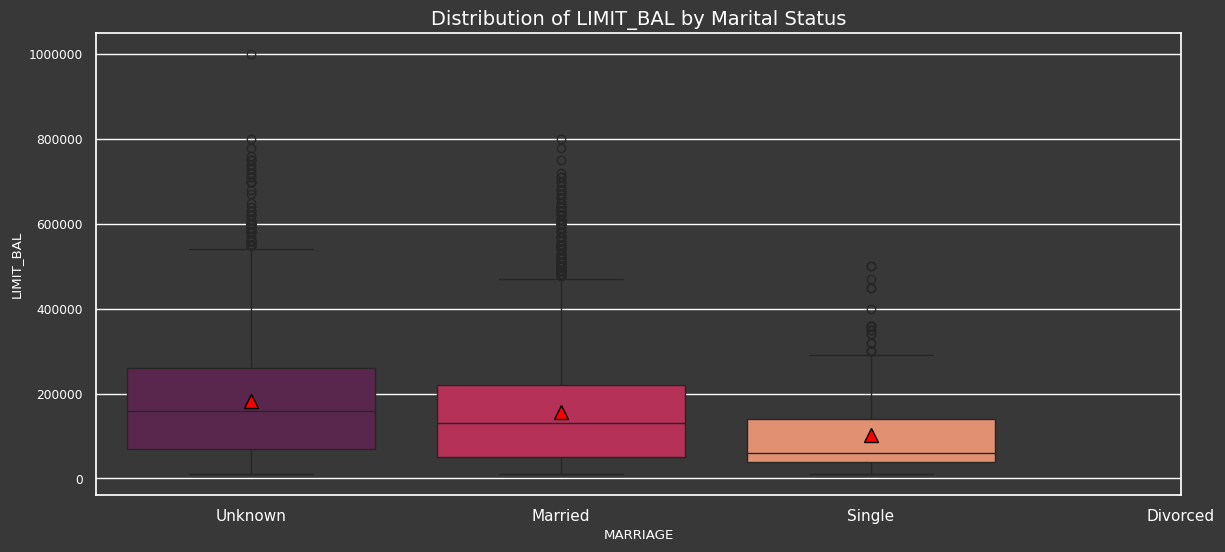

In [48]:
plt.figure(figsize=(14, 6))

sns.boxplot(x="MARRIAGE", y="LIMIT_BAL", data=df, palette='rocket', showmeans=True,
            meanprops={"markerfacecolor": "red", "markeredgecolor": "black", "markersize": "10"})

plt.title('Distribution of LIMIT_BAL by Marital Status', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks([0, 1, 2, 3], ['Unknown', 'Married', 'Single', 'Divorced'], fontsize=11)

plt.show()


In [49]:
dfAge.groupby('AgeBin')['LIMIT_BAL'].mean()

,LIMIT_BAL
AgeBin,
"(20, 25]",73763.885301
"(25, 30]",164320.918510
"(30, 35]",197688.060732
"(35, 40]",196780.557250
"(40, 50]",179680.213156
"(50, 60]",159349.023535
"(60, 80]",201617.647059


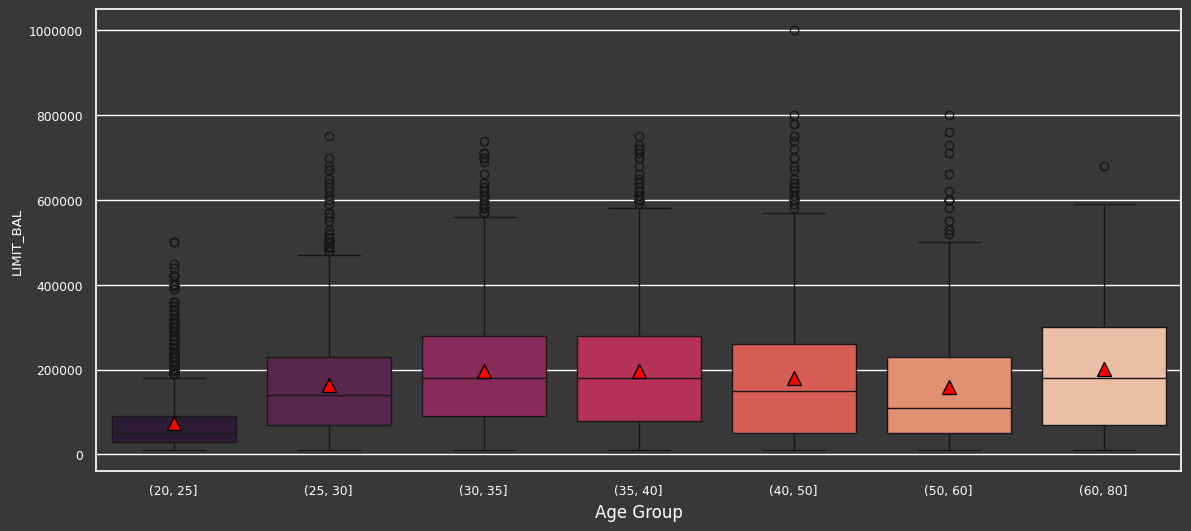

In [50]:
plt.figure(figsize=(14,6))

sns.boxplot(x = "AgeBin", y = "LIMIT_BAL",data = dfAge, palette = 'rocket', order = AgeBin_order, showmeans=True,
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation
plt.xlabel("Age Group", fontsize= 12)

plt.show()


Overall, the offered credit limit seems to match the ability to pay in time within each category. The exceptions are the unknown categories, which have lower chances of default, but do not lead in the amount of given credit, and the age group of 60+, which, despite having one of the highest chances of default, receives, on average, the highest credit value.by age group.

We could analyze the relationship between the credit limit and the combination of two demographic features to see if we can find something different. In this notebook, I’ll only plot the ‘sex’ feature combined with the remaining demographic features.

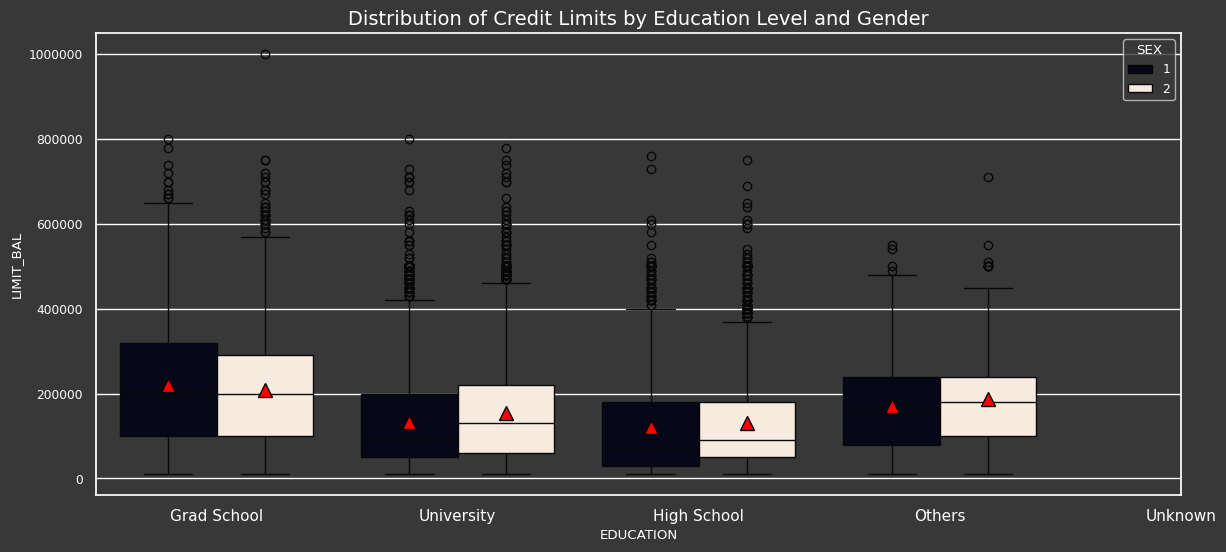

In [51]:
plt.figure(figsize=(14,6))

sns.boxplot(x = "EDUCATION", y = "LIMIT_BAL", hue = 'SEX', data = df, palette = 'rocket', showmeans=True,
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y')  # repressing scientific notation
plt.xticks([0, 1, 2, 3, 4], ['Grad School', 'University', 'High School', 'Others', 'Unknown'], fontsize=11)
plt.title("Distribution of Credit Limits by Education Level and Gender", fontsize=14, color='white')

plt.show()


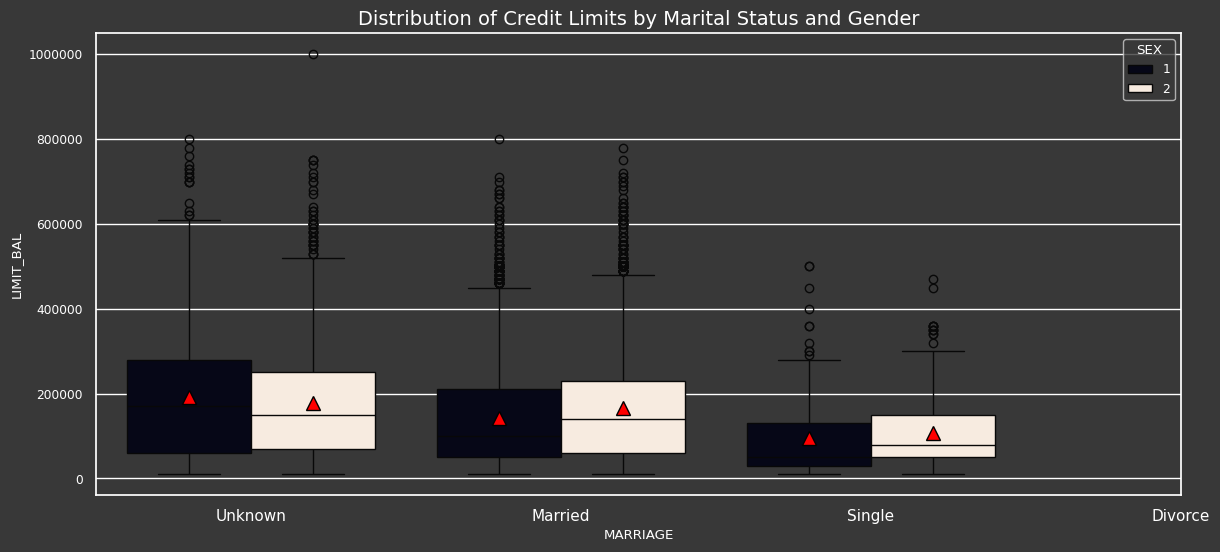

In [52]:
plt.figure(figsize=(14,6))

sns.boxplot(x = "MARRIAGE", y = "LIMIT_BAL", hue = 'SEX', data = df, palette = 'rocket', showmeans=True,
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y')  # repressing scientific notation
plt.xticks([0, 1, 2, 3], ['Unknown', 'Married', 'Single', 'Divorce'], fontsize=11)
plt.title("Distribution of Credit Limits by Marital Status and Gender", fontsize=14, color='white')

plt.show()


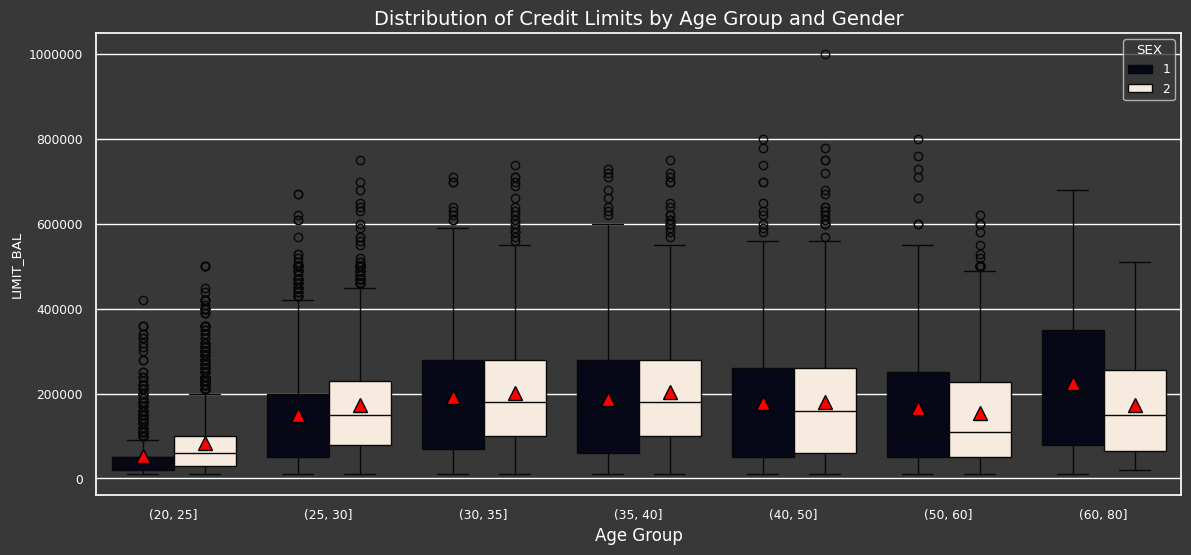

In [154]:
plt.figure(figsize=(14,6))

sns.boxplot(x = "AgeBin", y = "LIMIT_BAL", hue = 'SEX', data = dfAge, palette = 'rocket', order = AgeBin_order, showmeans=True,
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y')  # repressing scientific notation
plt.xlabel("Age Group", fontsize=12)
plt.title("Distribution of Credit Limits by Age Group and Gender", fontsize=14, color='white')

plt.show()


We saw earlier that the average given credit for women was slightly higher than for men. That still holds up for several combinations of categories, except among customers that:

Have a grad school diploma;
Are married;
Are 50+ years old.

### Repayment Status (PAY_X)


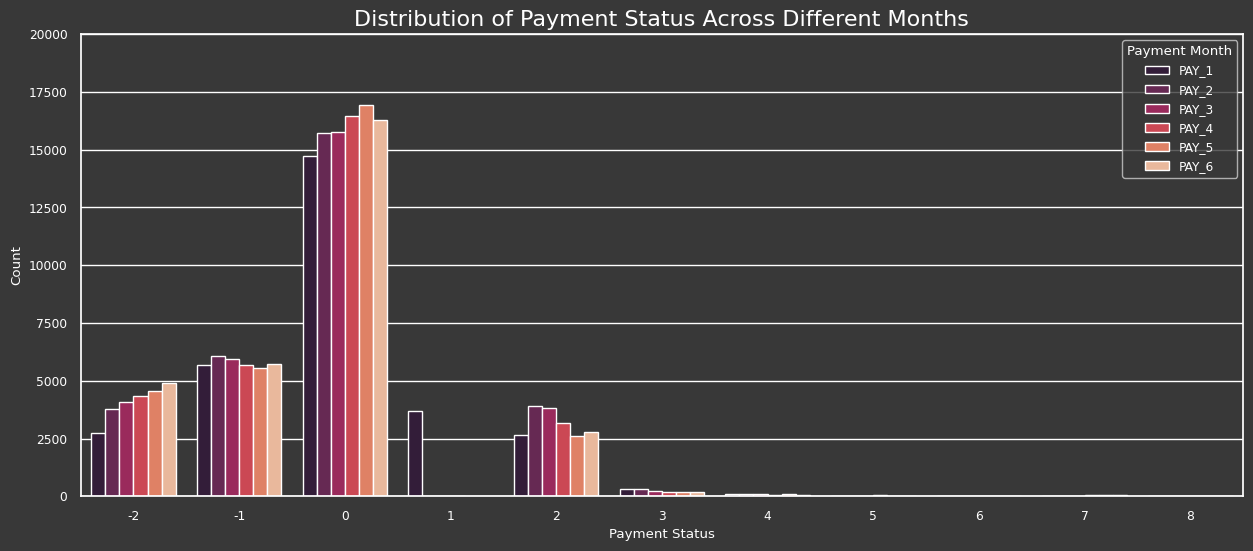

In [67]:
pay_x_fts = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Melt the DataFrame to long format for easier plotting
melted_df = df.melt(value_vars=pay_x_fts, var_name='Payment Month', value_name='Payment Status')

# Create a count plot
plt.figure(figsize=(15, 6))
ax = sns.countplot(data=melted_df, x='Payment Status', hue='Payment Month', palette='rocket')
plt.ylim(0, 20000)
plt.ylabel('Count')
plt.title("Distribution of Payment Status Across Different Months", fontsize=16, color='white')

plt.show()


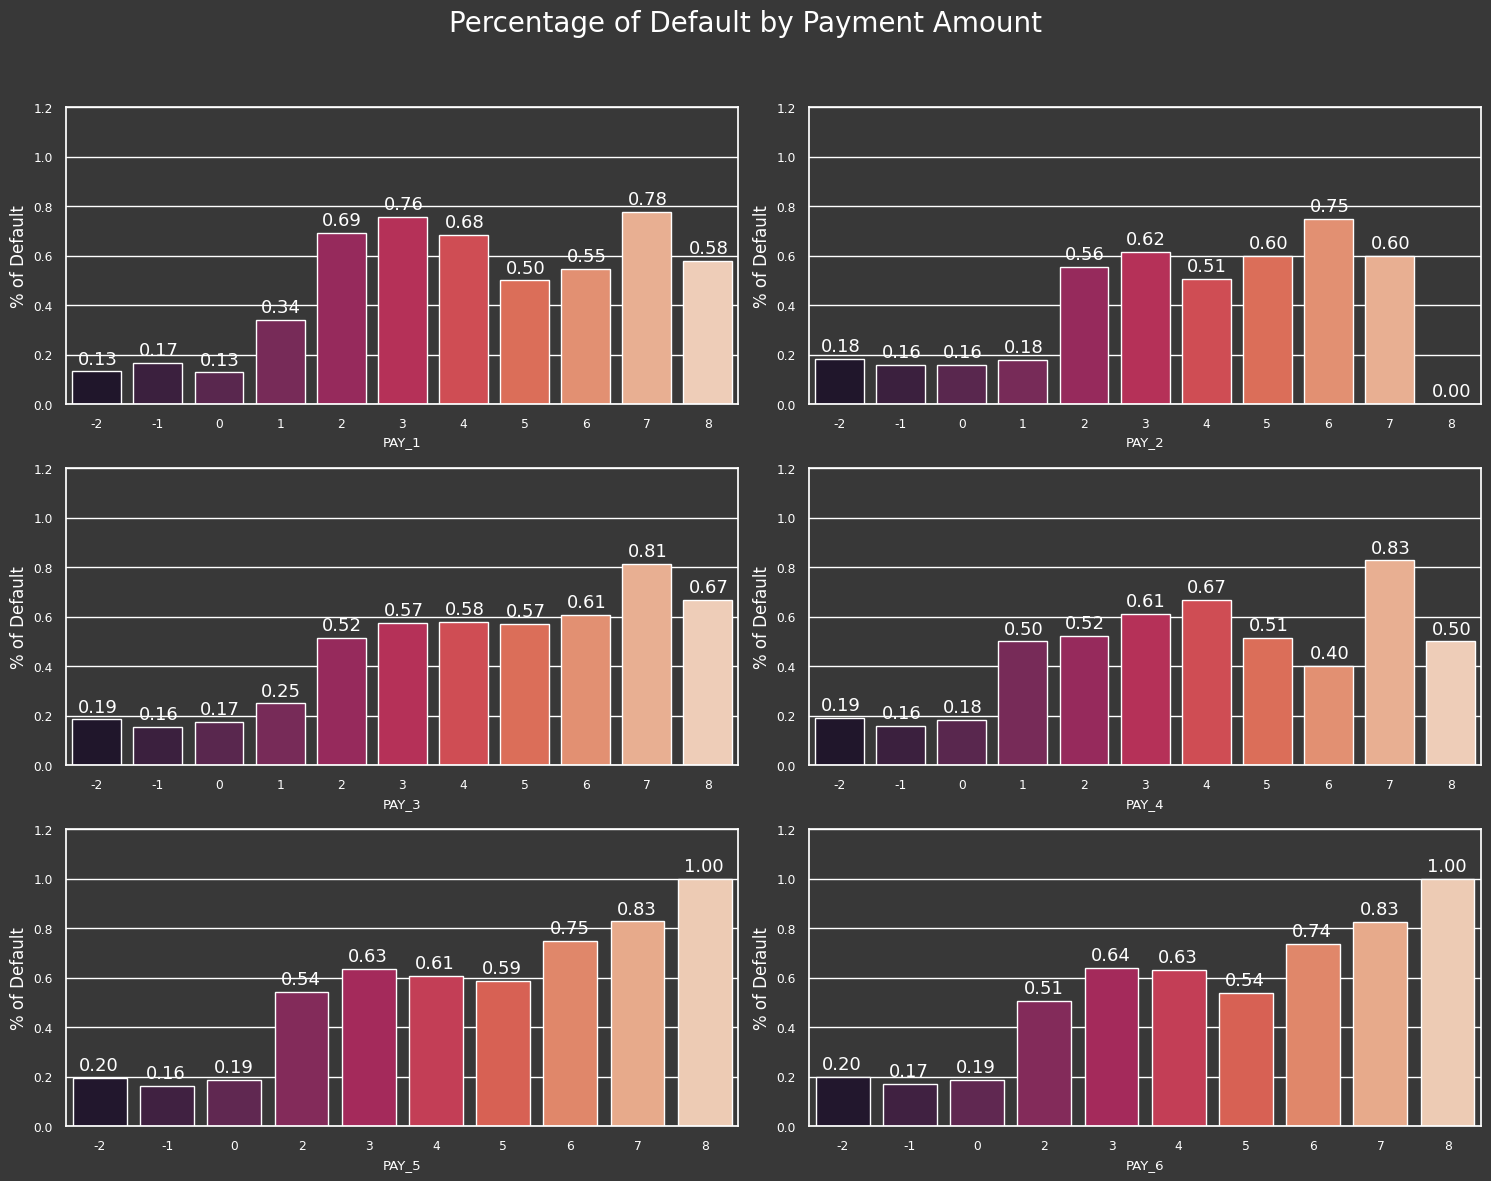

In [68]:
plt.figure(figsize=(15, 12))

plt.suptitle("Percentage of Default by Payment Amount", fontsize=20, color='white')

for i, col in enumerate(pay_x_fts):
    plt.subplot(3, 2, i + 1)
    ax = sns.barplot(x=col, y="Default", data=df, palette='rocket', ci=None)
    plt.ylabel("% of Default", fontsize=12)
    plt.ylim(0, 1.2)
    plt.tight_layout()

    for p in ax.patches:
        ax.annotate("%.2f" % (p.get_height()), (p.get_x() + 0.09, p.get_height() + 0.03), fontsize=13)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
plt.show()


Most customers are duly paying their credit card bills. And it's pretty clear that their likelihood of default are much lower than the rest.

Since there are only a few customers with 4+ months of delay in all PAY_X features, we could make a new analysis with them all together just to have the average default of a more significant group.

In [69]:
df['PAY_1_new'] = df['PAY_1'].copy()
df['PAY_2_new'] = df['PAY_2'].copy()
df['PAY_3_new'] = df['PAY_3'].copy()
df['PAY_4_new'] = df['PAY_4'].copy()
df['PAY_5_new'] = df['PAY_5'].copy()
df['PAY_6_new'] = df['PAY_6'].copy()

In [70]:
pay_x_new = ['PAY_1_new', 'PAY_2_new', 'PAY_3_new', 'PAY_4_new', 'PAY_5_new', 'PAY_6_new']

# Iterate over each column in the list to standardize payment statuses
for col in pay_x_new:
    # Replace payment status of 5 with 4
    # Values 5, 6, 7, and 8 likely indicate different degrees of delayed payments.
    # By replacing these values with 4, we consolidate multiple negative payment statuses into a single category.
    df.loc[:, col] = df.loc[:, col].replace(5, 4)

    # Replace payment status of 6 with 4
    df.loc[:, col] = df.loc[:, col].replace(6, 4)

    # Replace payment status of 7 with 4
    df.loc[:, col] = df.loc[:, col].replace(7, 4)

    # Replace payment status of 8 with 4
    df.loc[:, col] = df.loc[:, col].replace(8, 4)

# This consolidation helps in simplifying the analysis by reducing the number of distinct payment statuses,
# making it easier to identify patterns in payment behavior and improving the interpretability of the results.


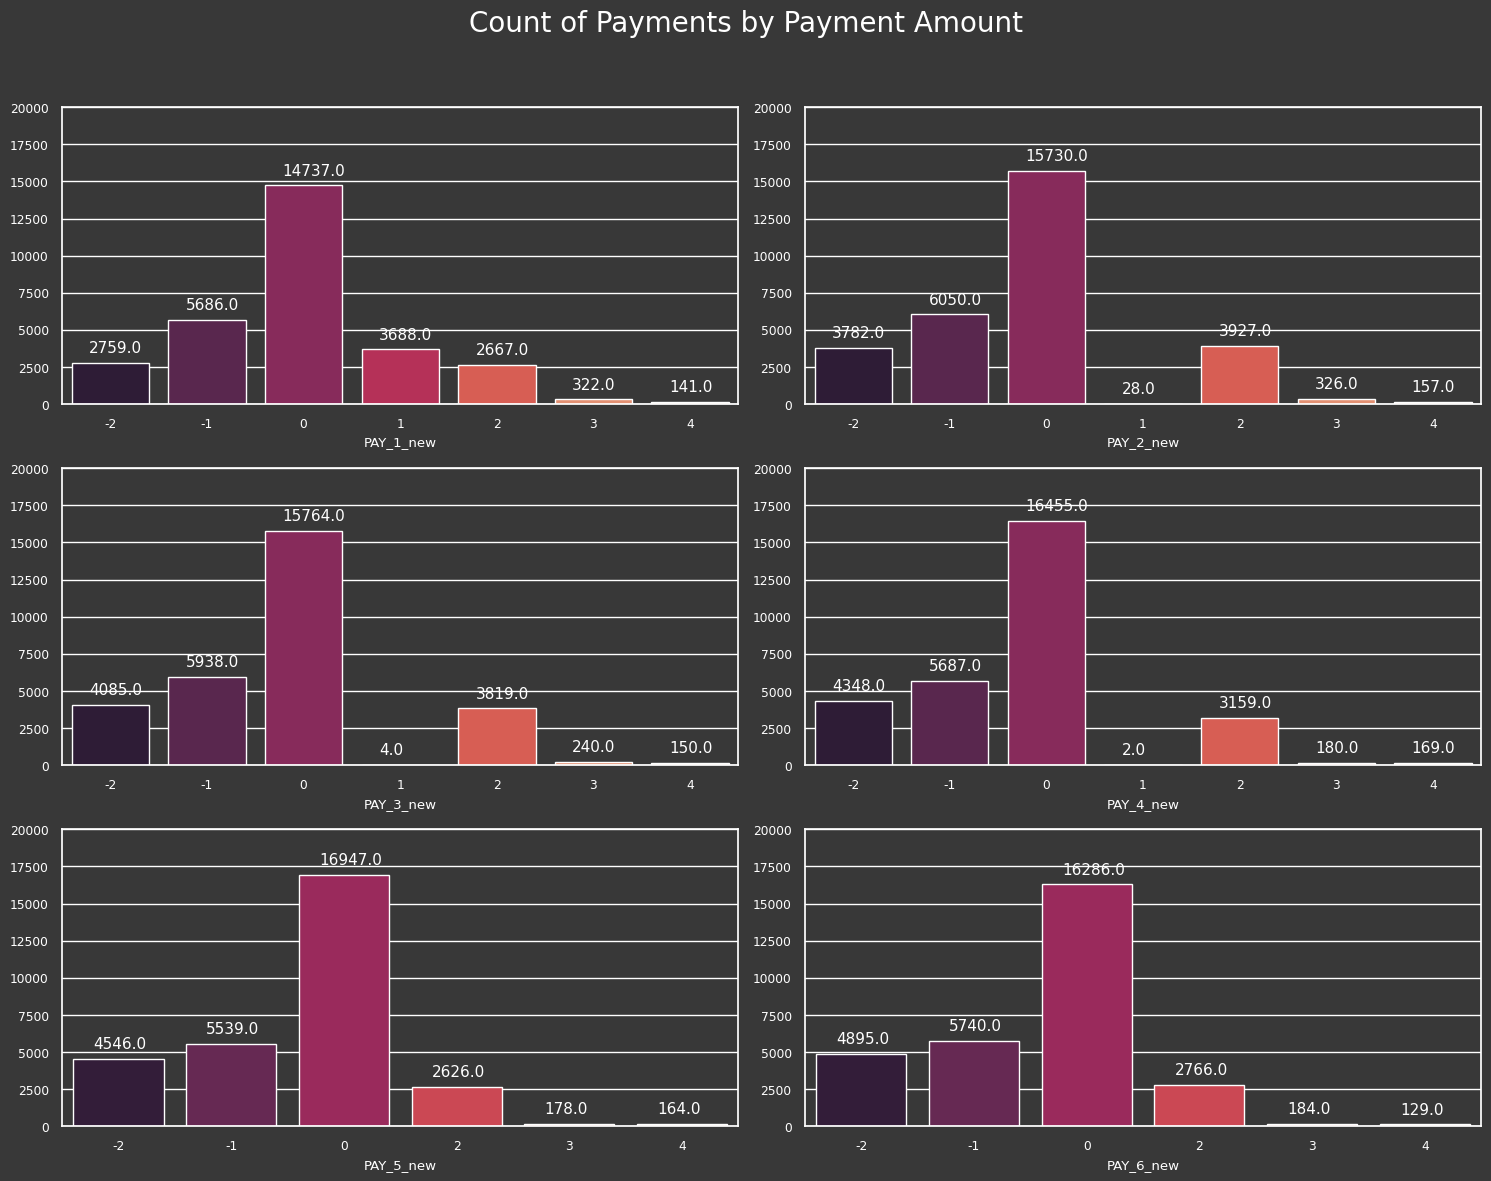

In [71]:
plt.figure(figsize=(15, 12))

plt.suptitle("Count of Payments by Payment Amount", fontsize=20, color='white')

for i, col in enumerate(pay_x_new):
    plt.subplot(3, 2, i + 1)
    ax = sns.countplot(data=df, x=col, palette='rocket')
    plt.ylim(0, 20000)
    plt.ylabel('')
    plt.tight_layout()

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x() + 0.180, p.get_height() + 700), fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
plt.show()


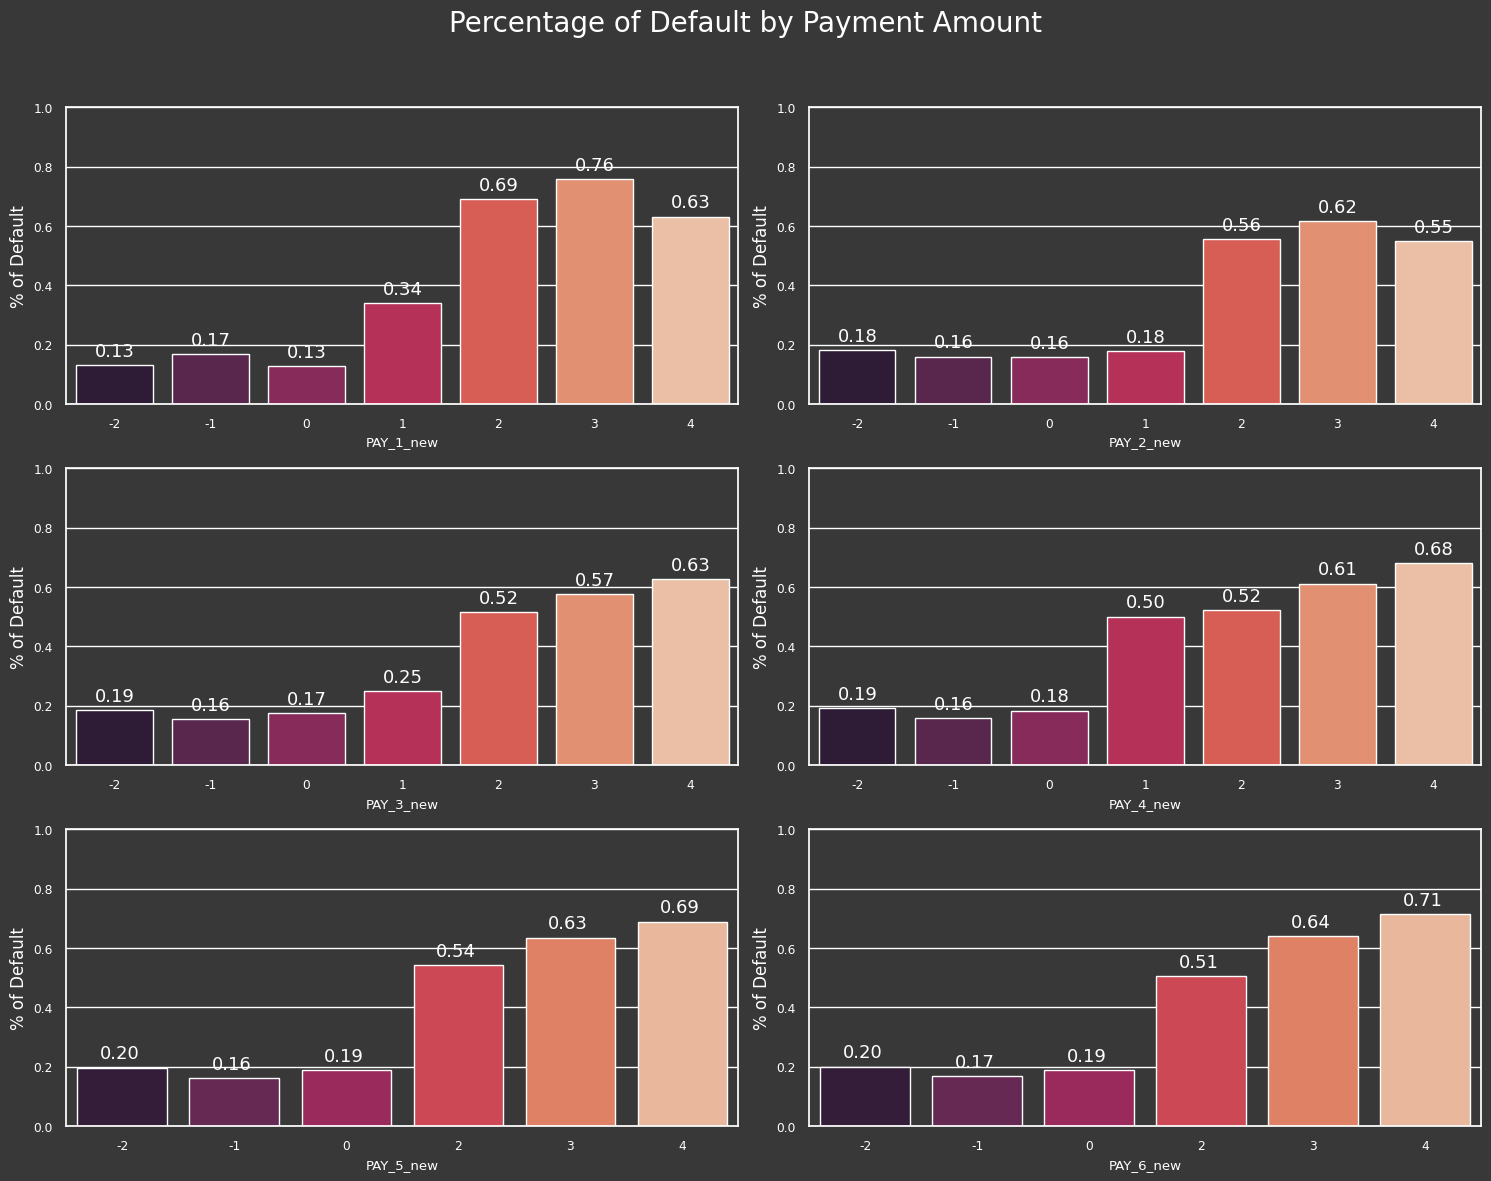

In [72]:
plt.figure(figsize=(15, 12))

plt.suptitle("Percentage of Default by Payment Amount", fontsize=20, color='white')

for i, col in enumerate(pay_x_new):
    plt.subplot(3, 2, i + 1)
    ax = sns.barplot(x=col, y="Default", data=df, palette='rocket', ci=None)
    plt.ylabel("% of Default", fontsize=12)
    plt.ylim(0, 1.0)
    plt.tight_layout()

    for p in ax.patches:
        ax.annotate("%.2f" % (p.get_height()), (p.get_x() + 0.20, p.get_height() + 0.03), fontsize=13)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
plt.show()


### Amount of Bill Statement (BILL_AMTX)

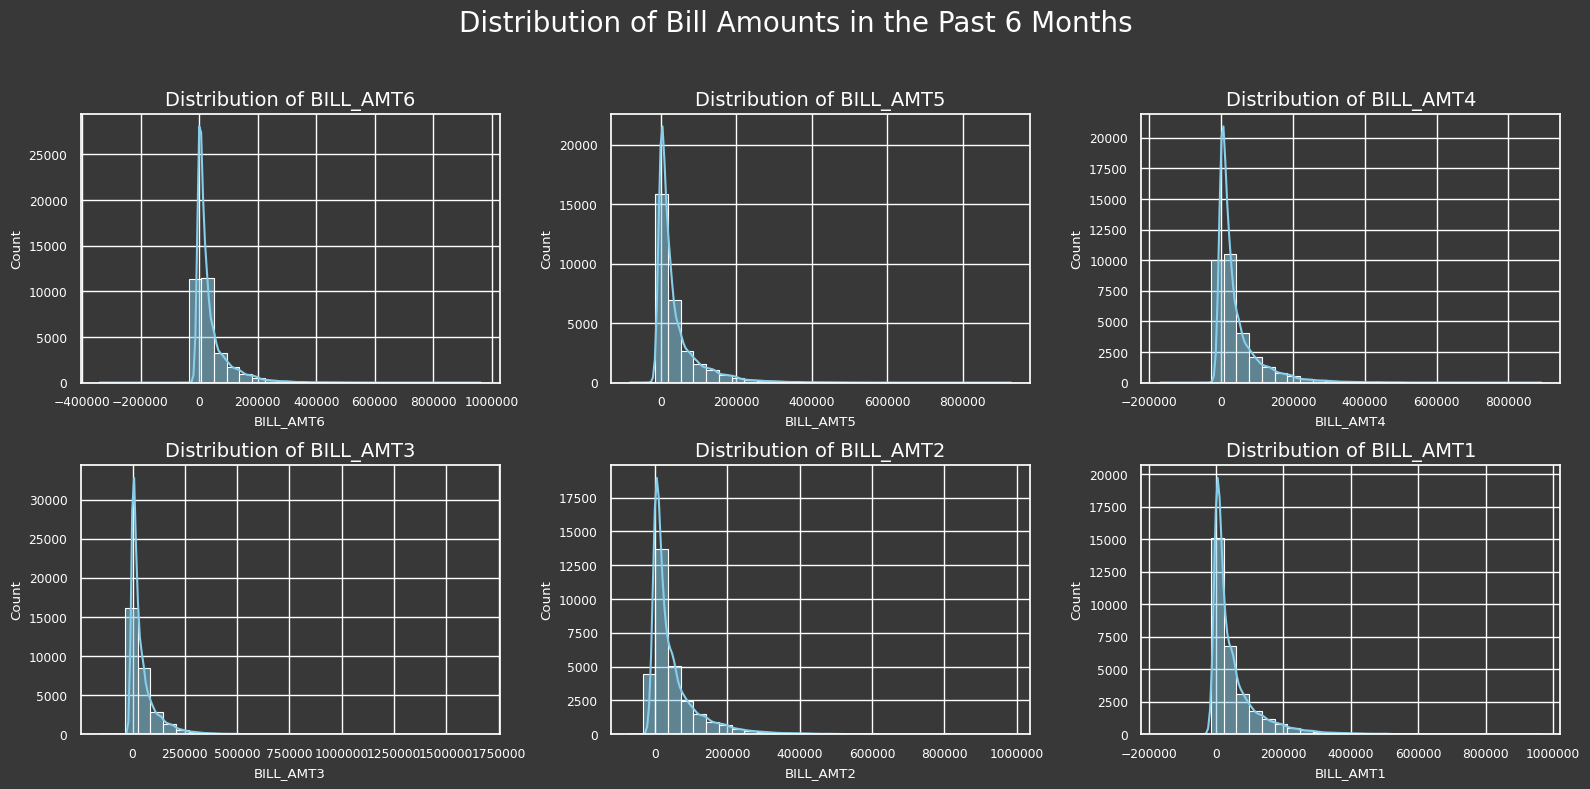

In [73]:
bill_amt_cols = ['BILL_AMT6', 'BILL_AMT5', 'BILL_AMT4', 'BILL_AMT3', 'BILL_AMT2', 'BILL_AMT1']
fig, ax = plt.subplots(2, 3, figsize=(16, 8))
ax = ax.flatten()

plt.suptitle("Distribution of Bill Amounts in the Past 6 Months", fontsize=20, color='white')

for i, col in enumerate(bill_amt_cols):
    sns.histplot(df[col], ax=ax[i], kde=True, bins=30, color='skyblue')
    ax[i].set_title(f'Distribution of {col}', fontsize=14)
    ax[i].ticklabel_format(style='plain', axis='x')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
plt.show()


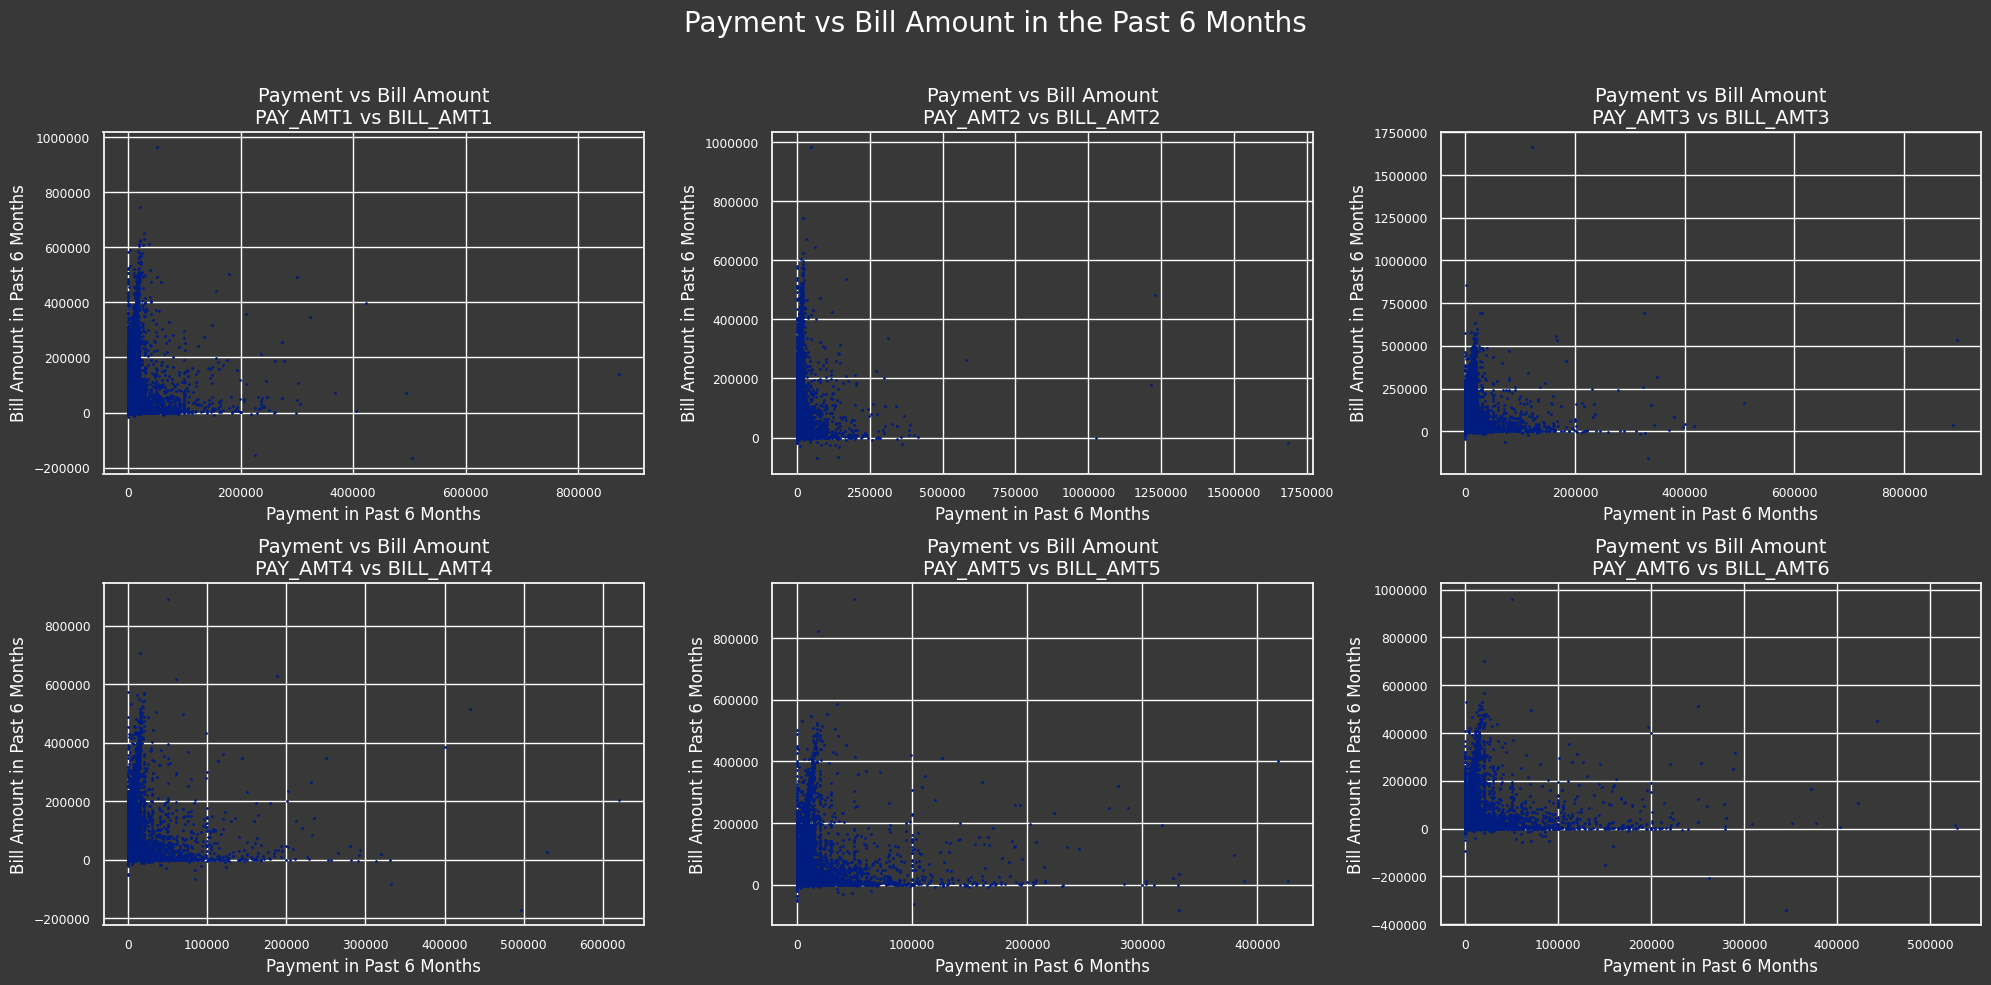

In [74]:
pay_amt_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
bill_amt_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax = ax.flatten()

plt.suptitle("Payment vs Bill Amount in the Past 6 Months", fontsize=20, color='white')  # Add the title

for i in range(6):
    ax[i].scatter(x=df[pay_amt_cols[i]], y=df[bill_amt_cols[i]], s=1)
    ax[i].set_title(f'Payment vs Bill Amount\n{pay_amt_cols[i]} vs {bill_amt_cols[i]}', fontsize=14)
    ax[i].set_xlabel("Payment in Past 6 Months", fontsize=12)
    ax[i].set_ylabel("Bill Amount in Past 6 Months", fontsize=12)
    ax[i].ticklabel_format(style='plain', axis='both')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the title
plt.show()


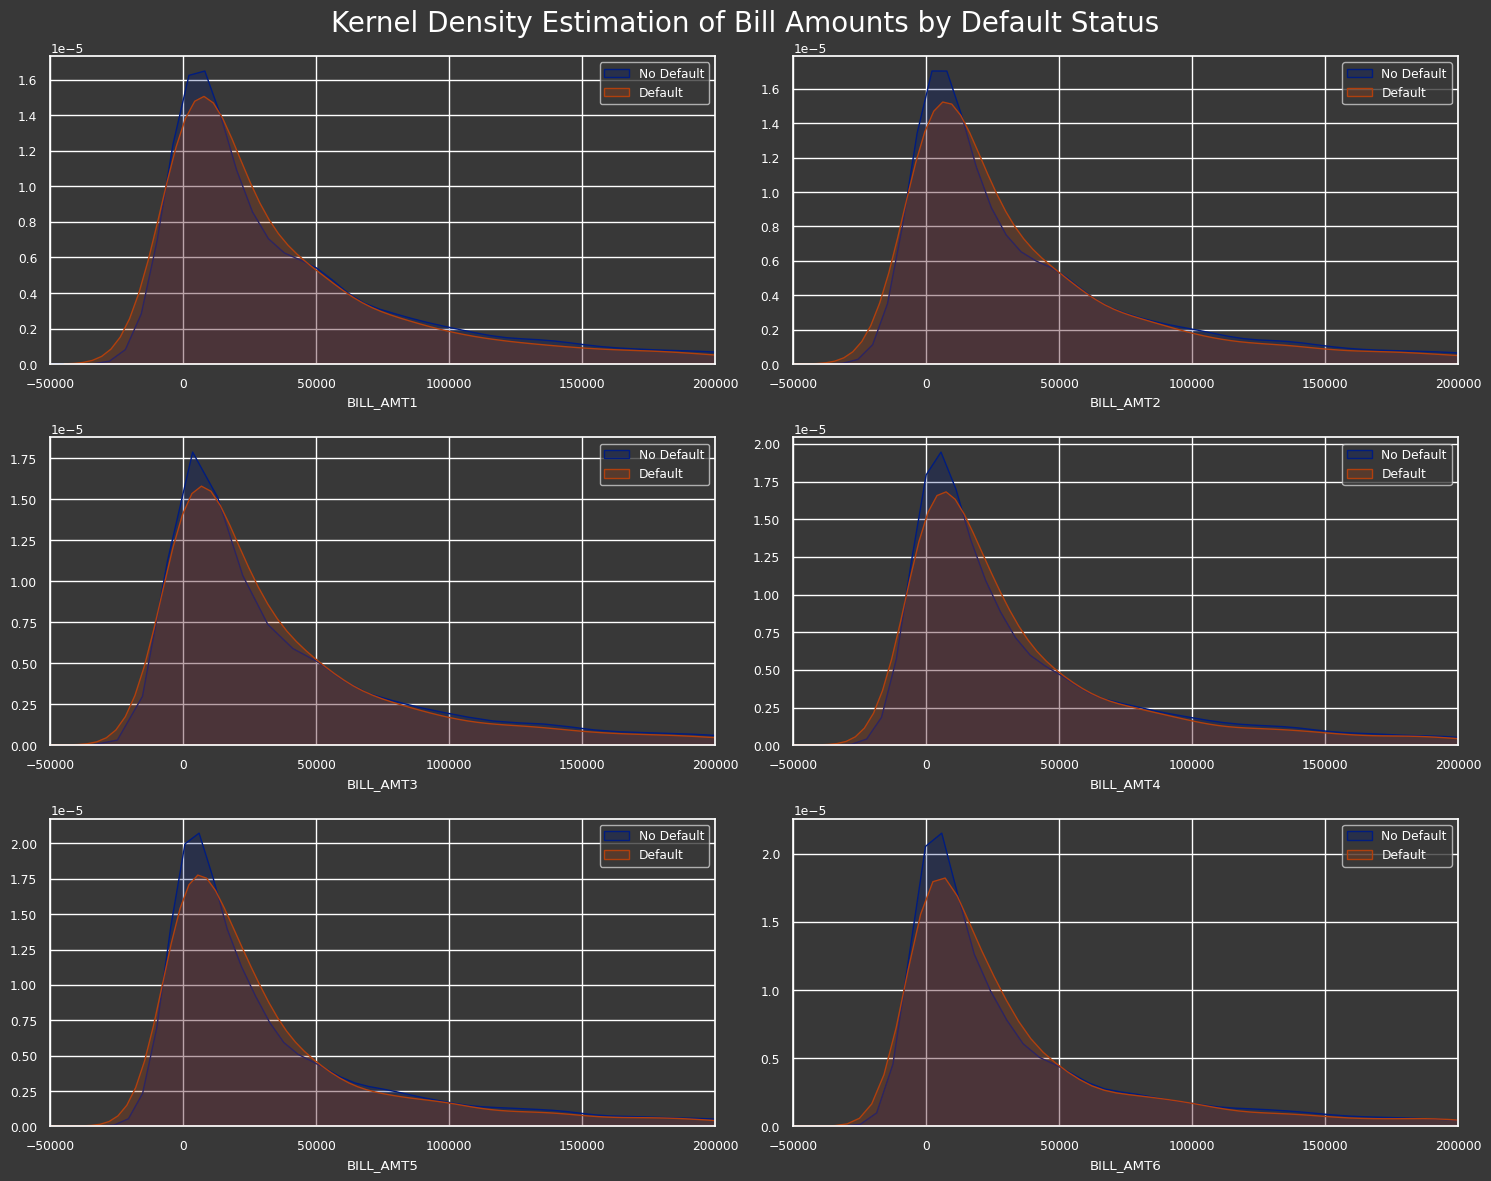

In [55]:
bill_amtx_fts = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
plt.figure(figsize=(15, 12))
plt.suptitle("Kernel Density Estimation of Bill Amounts by Default Status", fontsize=20, color='white')  # Add the title

for i, col in enumerate(bill_amtx_fts):
    plt.subplot(3, 2, i + 1)
    sns.kdeplot(df.loc[(df['Default'] == 0), col], label='No Default', shade=True)
    sns.kdeplot(df.loc[(df['Default'] == 1), col], label='Default', shade=True)
    plt.xlim(-50000, 200000)
    plt.ylabel('')
    plt.legend()
    plt.tight_layout()

plt.show()


In [56]:
df['BILL_AMT1_bin'] = df['BILL_AMT1'].copy()
df['BILL_AMT2_bin'] = df['BILL_AMT2'].copy()
df['BILL_AMT3_bin'] = df['BILL_AMT3'].copy()
df['BILL_AMT4_bin'] = df['BILL_AMT4'].copy()
df['BILL_AMT5_bin'] = df['BILL_AMT5'].copy()
df['BILL_AMT6_bin'] = df['BILL_AMT6'].copy()

In [57]:
bill_amtx_bins = ['BILL_AMT1_bin', 'BILL_AMT2_bin', 'BILL_AMT3_bin', 'BILL_AMT4_bin', 'BILL_AMT5_bin', 'BILL_AMT6_bin']

for i, col in enumerate (bill_amtx_bins):
    df[col] = pd.cut(df[bill_amtx_fts[i]],[-350000,-1,0,25000, 75000, 200000, 2000000])
    print(df[col].value_counts())

BILL_AMT1_bin
(0, 25000]           12965
(25000, 75000]        7656
(75000, 200000]       5258
(-1, 0]               2008
(200000, 2000000]     1523
(-350000, -1]          590
Name: count, dtype: int64
BILL_AMT2_bin
(0, 25000]           12647
(25000, 75000]        7692
(75000, 200000]       5094
(-1, 0]               2506
(200000, 2000000]     1392
(-350000, -1]          669
Name: count, dtype: int64
BILL_AMT3_bin
(0, 25000]           12696
(25000, 75000]        7635
(75000, 200000]       4888
(-1, 0]               2870
(200000, 2000000]     1256
(-350000, -1]          655
Name: count, dtype: int64
BILL_AMT4_bin
(0, 25000]           13081
(25000, 75000]        7401
(75000, 200000]       4623
(-1, 0]               3195
(200000, 2000000]     1025
(-350000, -1]          675
Name: count, dtype: int64
BILL_AMT5_bin
(0, 25000]           13401
(25000, 75000]        7163
(75000, 200000]       4399
(-1, 0]               3506
(200000, 2000000]      876
(-350000, -1]          655
Name: count, dty

In [58]:
for col in bill_amtx_bins:
    print(df['Default'].groupby(df[col]).value_counts(normalize = True))

BILL_AMT1_bin      Default
(-350000, -1]      0          0.815254
                   1          0.184746
(-1, 0]            0          0.734064
                   1          0.265936
(0, 25000]         0          0.774470
                   1          0.225530
(25000, 75000]     0          0.775209
                   1          0.224791
(75000, 200000]    0          0.802396
                   1          0.197604
(200000, 2000000]  0          0.797111
                   1          0.202889
Name: proportion, dtype: float64
BILL_AMT2_bin      Default
(-350000, -1]      0          0.810164
                   1          0.189836
(-1, 0]            0          0.753791
                   1          0.246209
(0, 25000]         0          0.775836
                   1          0.224164
(25000, 75000]     0          0.773531
                   1          0.226469
(75000, 200000]    0          0.799176
                   1          0.200824
(200000, 2000000]  0          0.790230
                

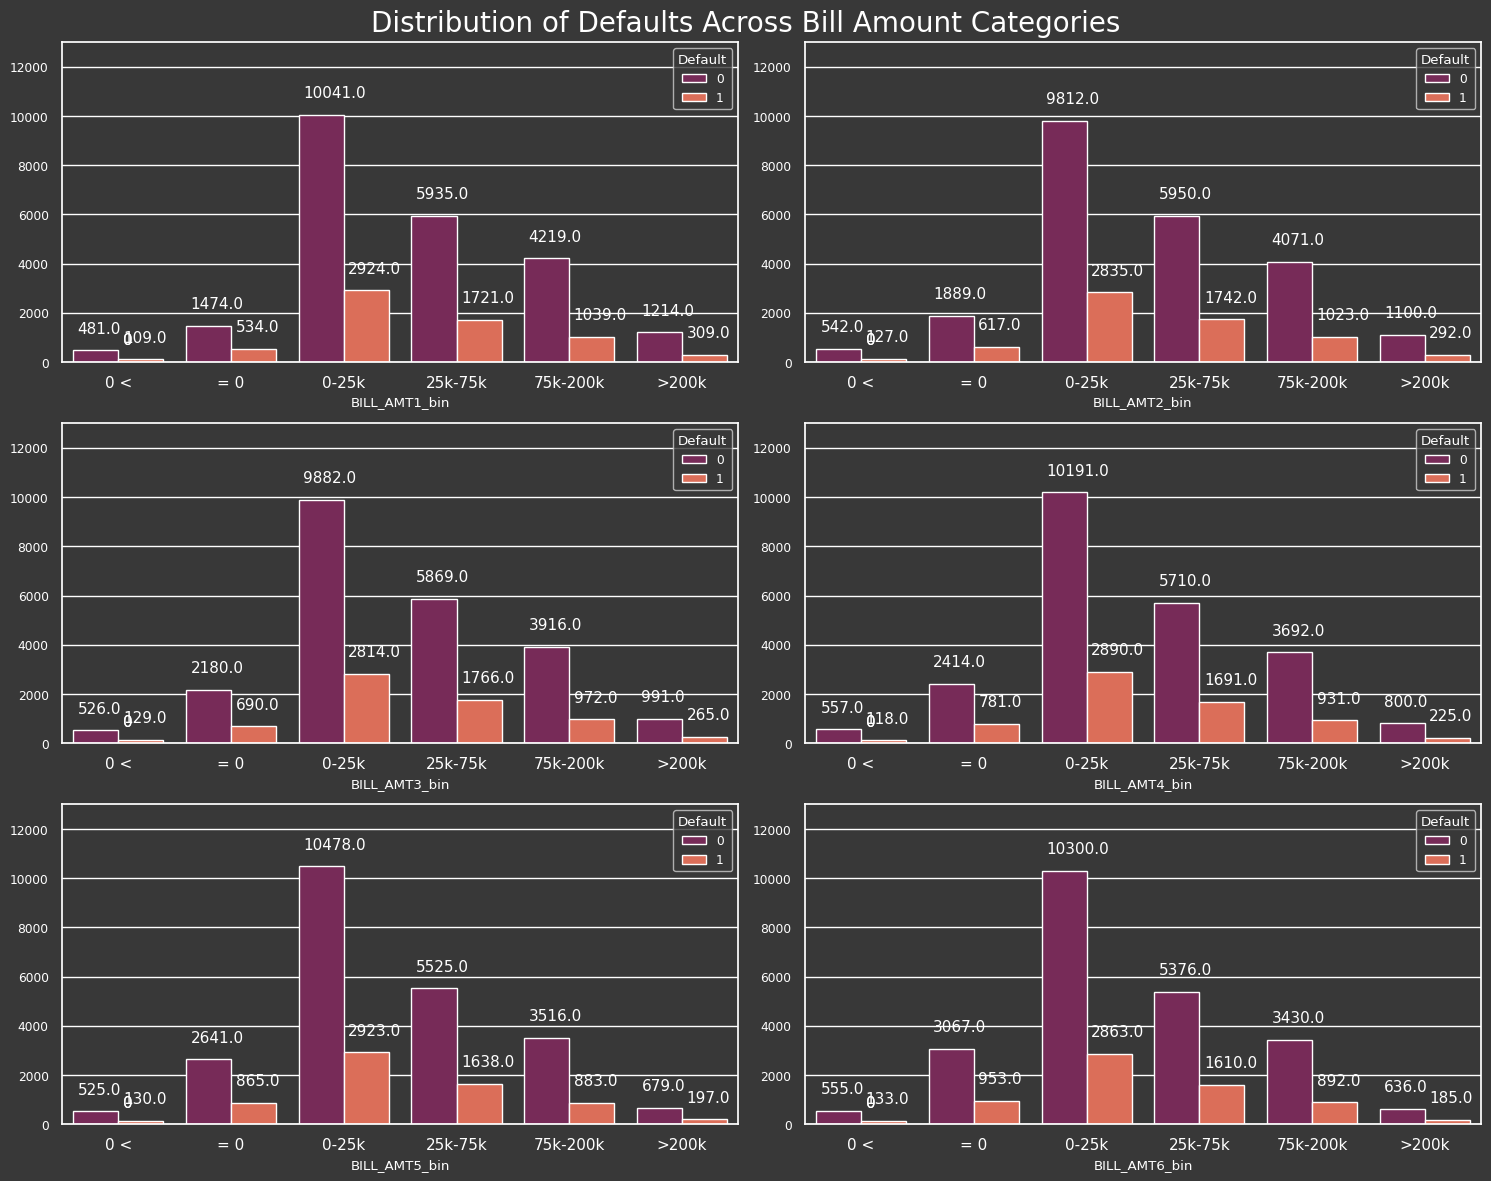

In [59]:
plt.figure(figsize=(15, 12))
plt.suptitle("Distribution of Defaults Across Bill Amount Categories", fontsize=20, color='white')  # Add the title

for i, col in enumerate(bill_amtx_bins):
    plt.subplot(3, 2, i + 1)
    ax = sns.countplot(data=df, x=col, hue="Default", palette='rocket')
    plt.ylim(0, 13000)
    plt.ylabel('')
    plt.xticks([0, 1, 2, 3, 4, 5], ['0 <', '= 0', '0-25k', '25k-75k', '75k-200k', '>200k'], fontsize=11)
    plt.tight_layout()

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x() + 0.04, p.get_height() + 700), fontsize=11)

plt.show()


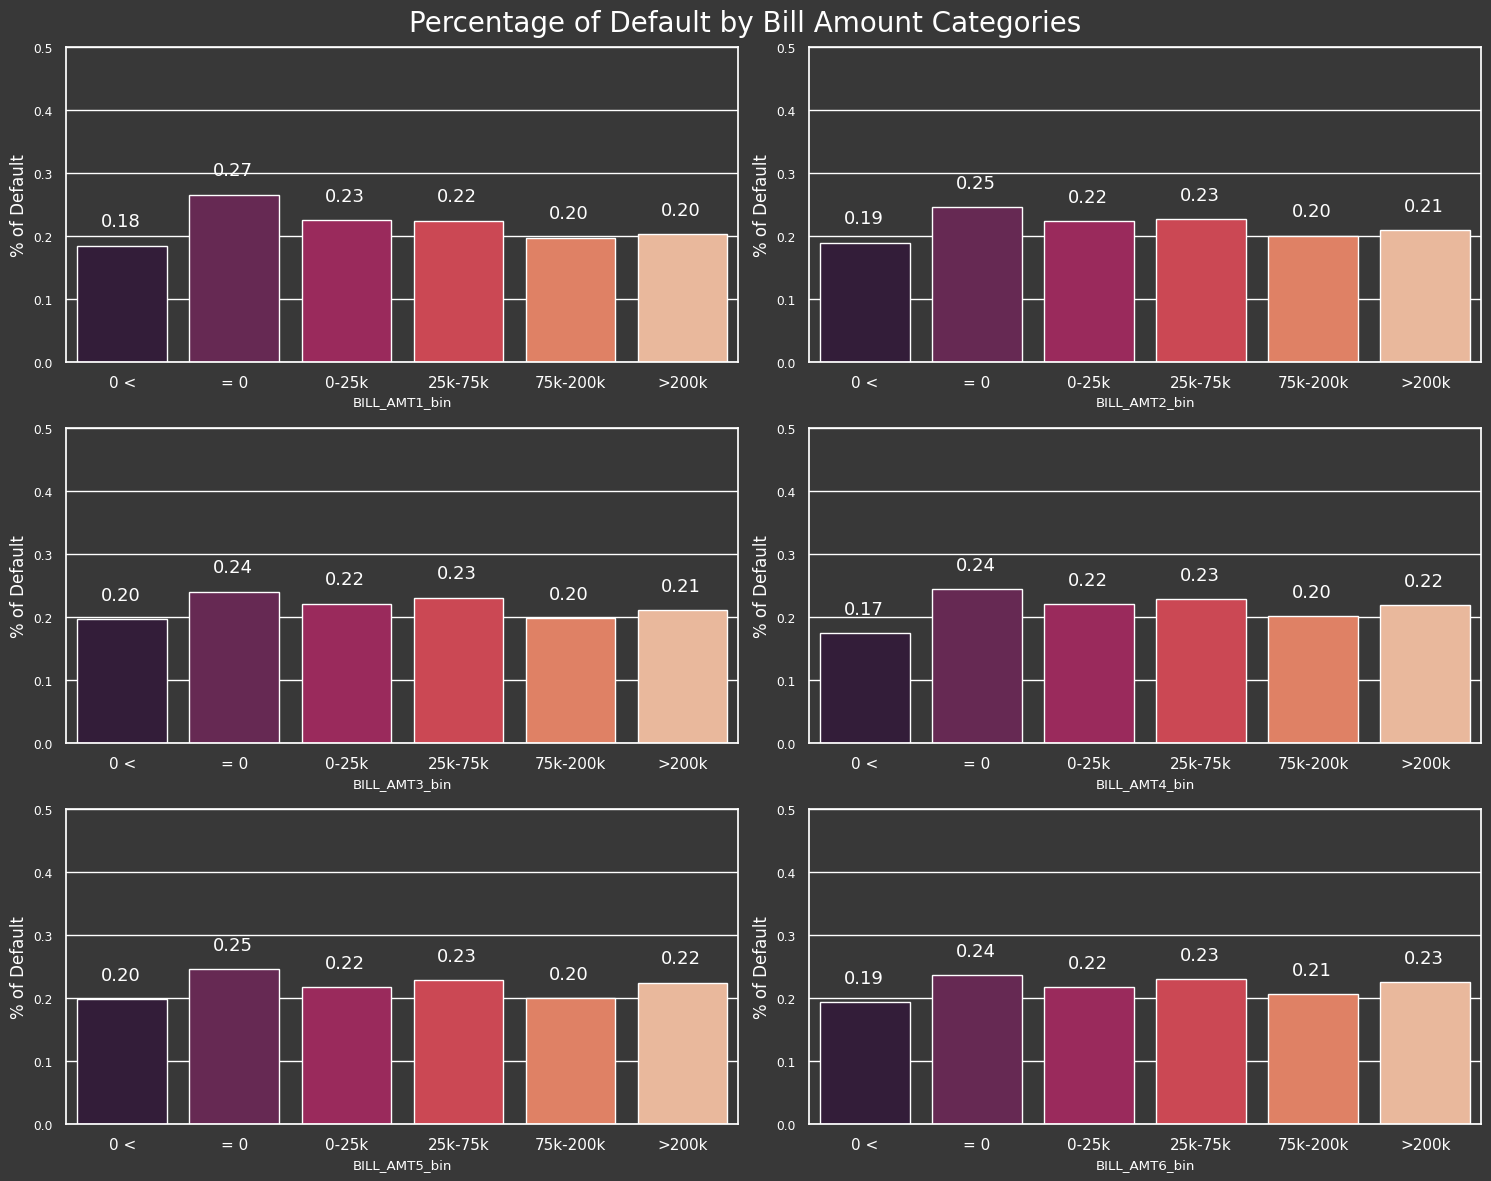

In [60]:
plt.figure(figsize=(15, 12))
plt.suptitle("Percentage of Default by Bill Amount Categories", fontsize=20, color='white')  # Add the title

for i, col in enumerate(bill_amtx_bins):
    plt.subplot(3, 2, i + 1)
    ax = sns.barplot(x=col, y="Default", data=df, palette='rocket', ci=None)
    plt.ylabel("% of Default", fontsize=12)
    plt.ylim(0, 0.5)
    plt.xticks([0, 1, 2, 3, 4, 5], ['0 <', '= 0', '0-25k', '25k-75k', '75k-200k', '>200k'], fontsize=11)
    plt.tight_layout()

    for p in ax.patches:
        ax.annotate("%.2f" % (p.get_height()), (p.get_x() + 0.21, p.get_height() + 0.03), fontsize=13)

plt.show()


As expected, those who have a negative bill statement have a lower chance of default than the rest. What stands out is that there is a little higher chance of default for those who didn't have a bill in the previous months.

### Amount of Previous Payment (PAY_AMTX)

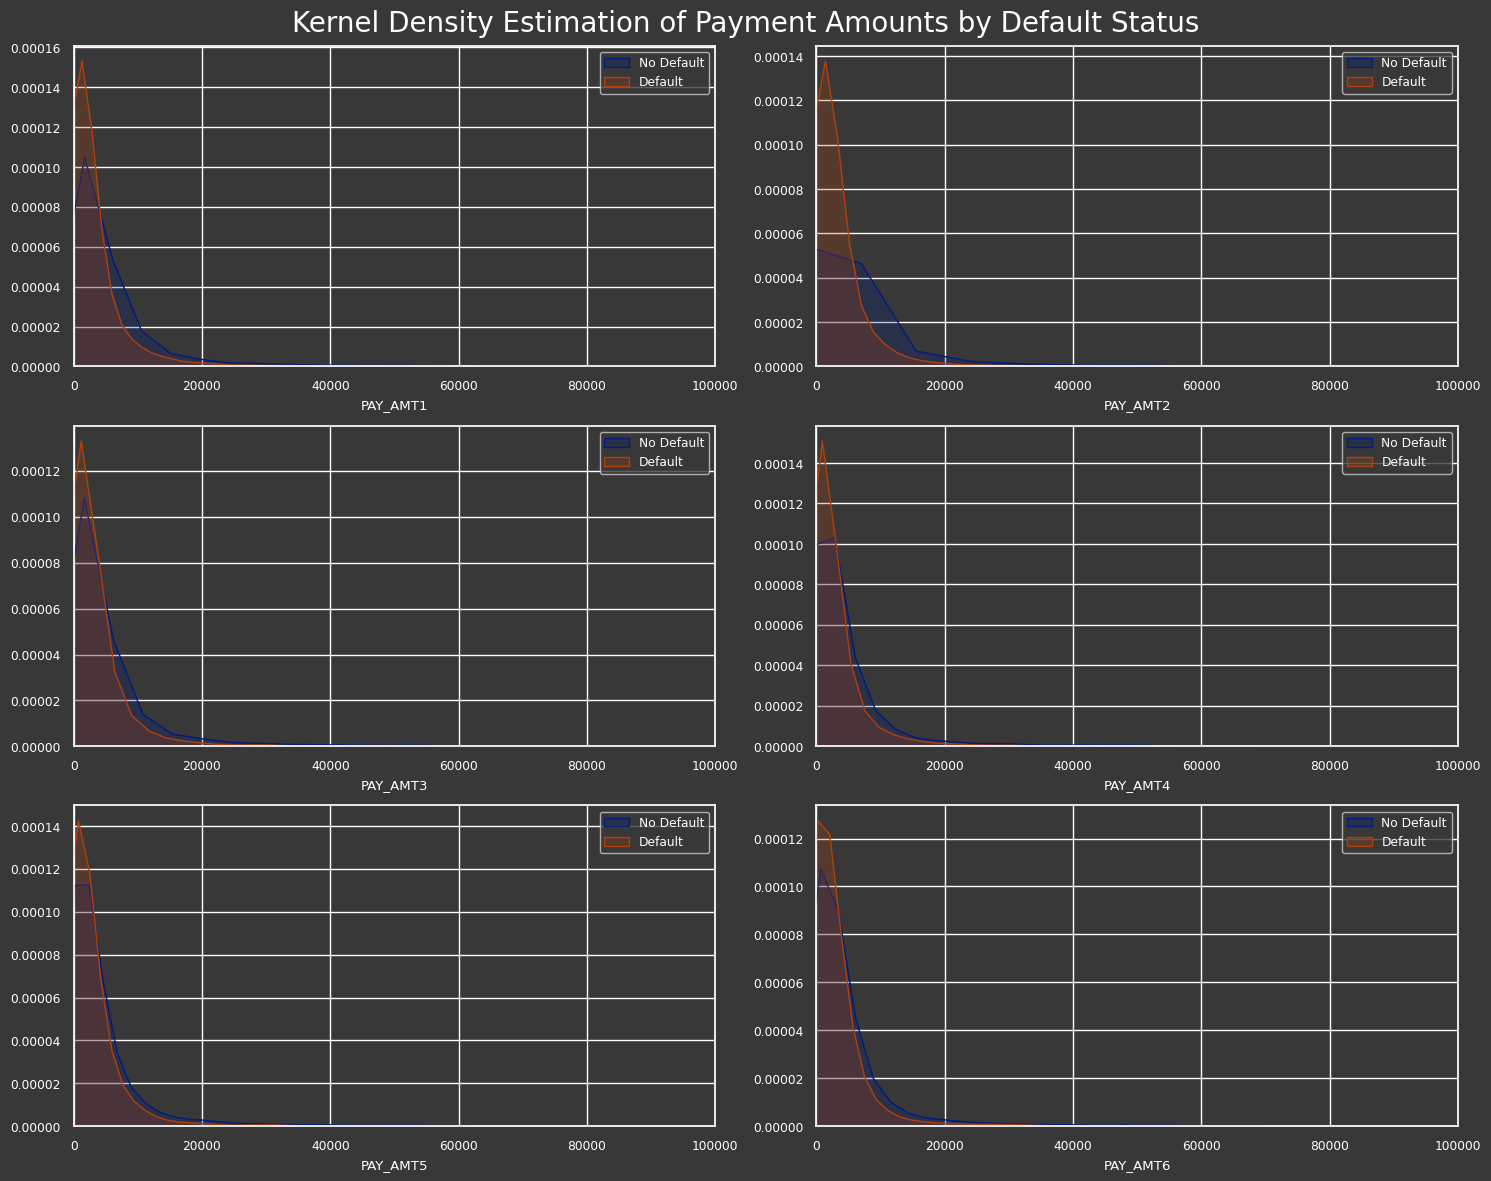

In [61]:
pay_amtx_fts = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
plt.figure(figsize=(15, 12))
plt.suptitle("Kernel Density Estimation of Payment Amounts by Default Status", fontsize=20, color='white')  # Add the title

for i, col in enumerate(pay_amtx_fts):
    plt.subplot(3, 2, i + 1)
    sns.kdeplot(df.loc[(df['Default'] == 0), col], label='No Default', shade=True)
    sns.kdeplot(df.loc[(df['Default'] == 1), col], label='Default', shade=True)
    plt.xlim(0, 100000)
    plt.ylabel('')
    plt.legend()
    plt.tight_layout()

plt.show()


In [62]:
df['PAY_AMT1_bin'] = df['PAY_AMT1'].copy()
df['PAY_AMT2_bin'] = df['PAY_AMT2'].copy()
df['PAY_AMT3_bin'] = df['PAY_AMT3'].copy()
df['PAY_AMT4_bin'] = df['PAY_AMT4'].copy()
df['PAY_AMT5_bin'] = df['PAY_AMT5'].copy()
df['PAY_AMT6_bin'] = df['PAY_AMT6'].copy()

In [63]:
pay_amtx_bins = ['PAY_AMT1_bin', 'PAY_AMT2_bin', 'PAY_AMT3_bin', 'PAY_AMT4_bin', 'PAY_AMT5_bin', 'PAY_AMT6_bin']

for i, col in enumerate (pay_amtx_bins):
    df[col] = pd.cut(df[pay_amtx_fts[i]],[-1, 0, 25000, 50000, 100000, 2000000])
    print(df[col].value_counts())

PAY_AMT1_bin
(0, 25000]           23730
(-1, 0]               5249
(25000, 50000]         550
(50000, 100000]        322
(100000, 2000000]      149
Name: count, dtype: int64
PAY_AMT2_bin
(0, 25000]           23569
(-1, 0]               5396
(25000, 50000]         556
(50000, 100000]        283
(100000, 2000000]      196
Name: count, dtype: int64
PAY_AMT3_bin
(0, 25000]           23068
(-1, 0]               5968
(25000, 50000]         514
(50000, 100000]        273
(100000, 2000000]      177
Name: count, dtype: int64
PAY_AMT4_bin
(0, 25000]           22641
(-1, 0]               6408
(25000, 50000]         533
(50000, 100000]        271
(100000, 2000000]      147
Name: count, dtype: int64
PAY_AMT5_bin
(0, 25000]           22382
(-1, 0]               6703
(25000, 50000]         493
(50000, 100000]        268
(100000, 2000000]      154
Name: count, dtype: int64
PAY_AMT6_bin
(0, 25000]           21785
(-1, 0]               7173
(25000, 50000]         517
(50000, 100000]        300
(100000, 

In [64]:
for col in pay_amtx_bins:
    print(df['Default'].groupby(df[col]).value_counts(normalize = True))

PAY_AMT1_bin       Default
(-1, 0]            0          0.640503
                   1          0.359497
(0, 25000]         0          0.803582
                   1          0.196418
(25000, 50000]     0          0.910909
                   1          0.089091
(50000, 100000]    0          0.919255
                   1          0.080745
(100000, 2000000]  0          0.912752
                   1          0.087248
Name: proportion, dtype: float64
PAY_AMT2_bin       Default
(-1, 0]            0          0.666605
                   1          0.333395
(0, 25000]         0          0.797997
                   1          0.202003
(25000, 50000]     0          0.926259
                   1          0.073741
(50000, 100000]    0          0.936396
                   1          0.063604
(100000, 2000000]  0          0.913265
                   1          0.086735
Name: proportion, dtype: float64
PAY_AMT3_bin       Default
(-1, 0]            0          0.676441
                   1          0.32

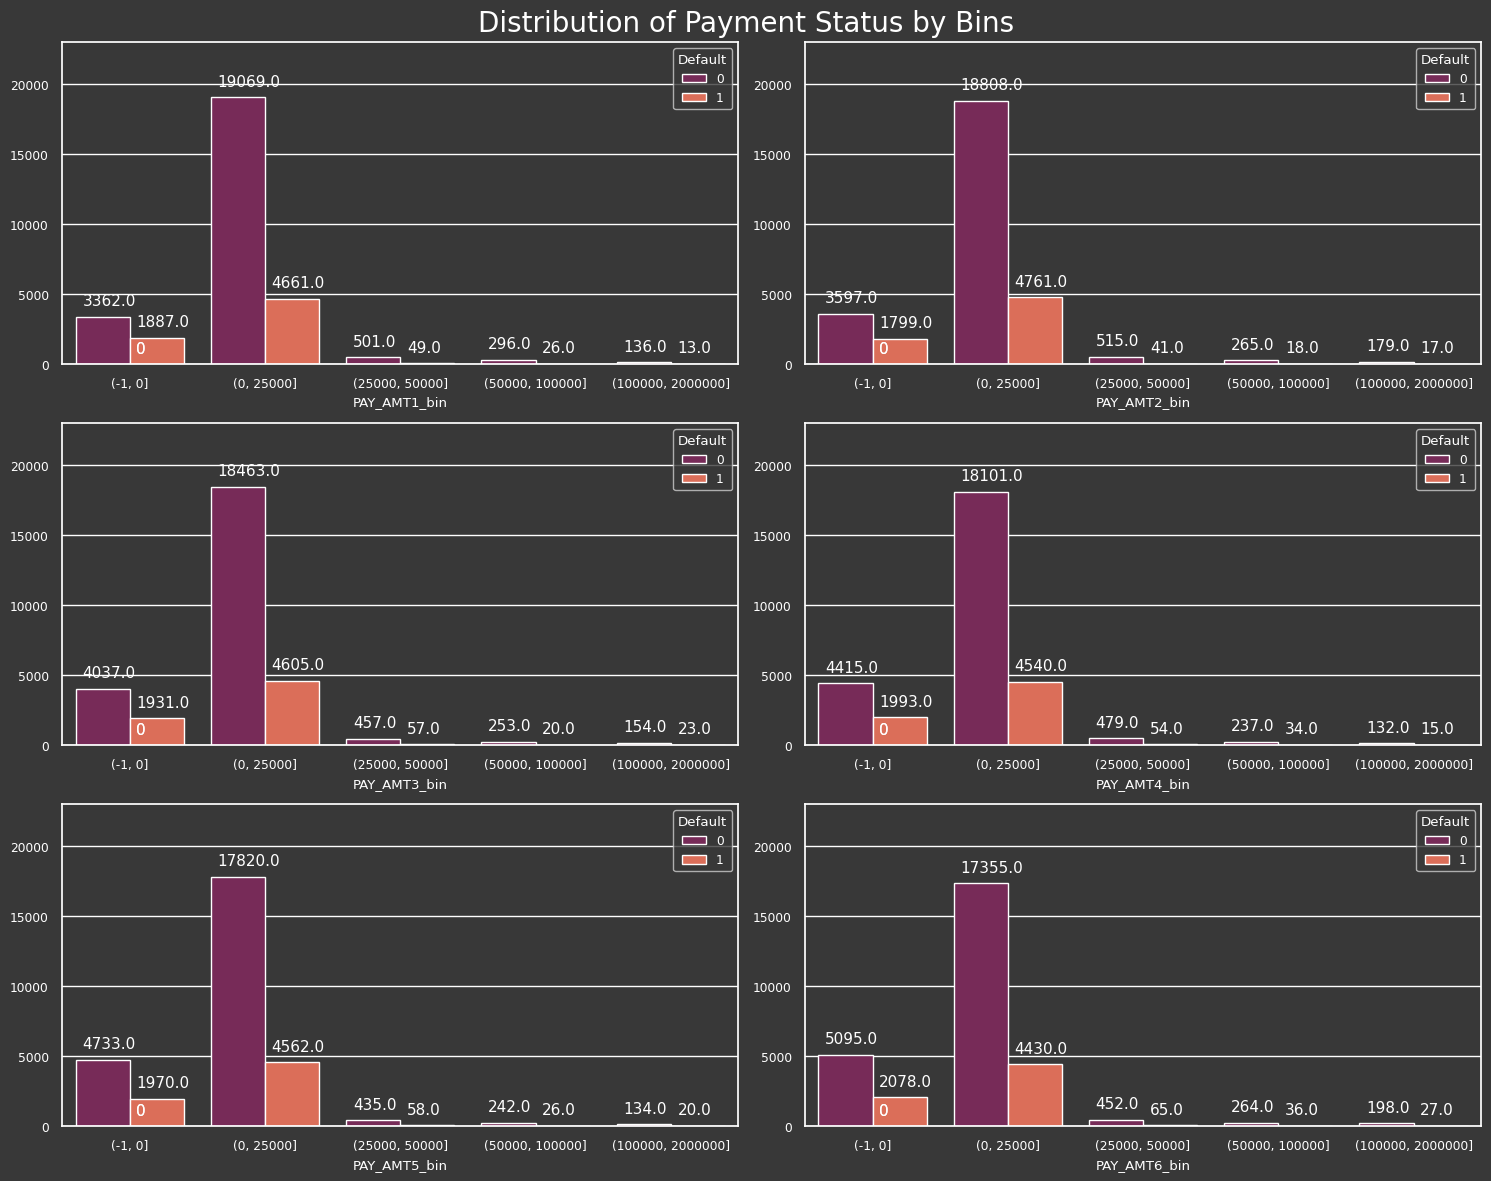

In [65]:
plt.figure(figsize=(15, 12))
plt.suptitle("Distribution of Payment Status by Bins", fontsize=20, color='white')  # Add the title

for i, col in enumerate(pay_amtx_bins):
    plt.subplot(3, 2, i + 1)
    ax = sns.countplot(data=df, x=col, hue="Default", palette='rocket')
    plt.ylim(0, 23000)
    plt.ylabel('')
    plt.tight_layout()

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x() + 0.05, p.get_height() + 800), fontsize=11)

plt.show()


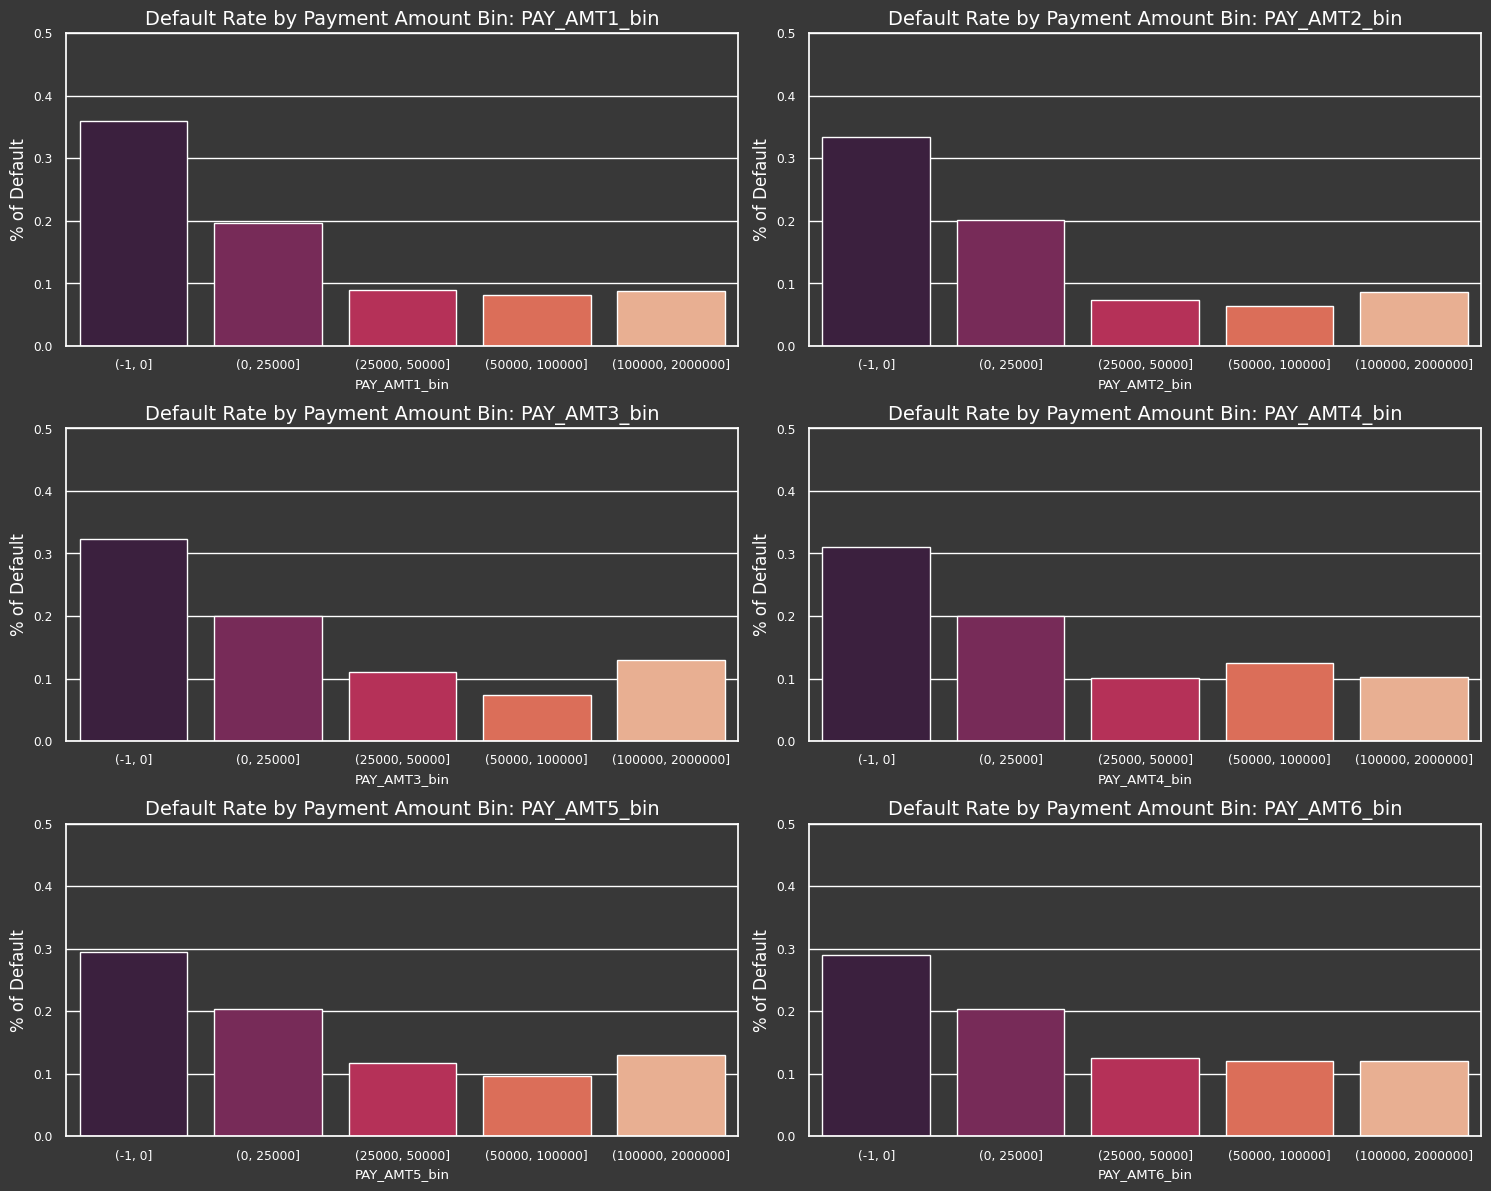

In [66]:
plt.figure(figsize=(15,12))

for i,col in enumerate(pay_amtx_bins):
    plt.subplot(3,2,i + 1)
    ax = sns.barplot(x = col, y = "Default", data = df, palette = 'rocket', ci = None)
    plt.ylabel("% of Default", fontsize= 12)
    plt.ylim(0,0.5)
    plt.title(f"Default Rate by Payment Amount Bin: {col}", fontsize=14)
    plt.tight_layout()


# Data Preprocessing

In [88]:
X_base = load_and_clean_data('default of credit card clients.xls')

In [89]:
X_base=X_base[X_base.MARRIAGE >0]

In [90]:
X_base=X_base[X_base.EDUCATION <5]

In [91]:
X_base.shape

(30000, 24)

In [92]:
X_base.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [93]:
X_base.shape

(30000, 24)

### SPLIT DATA

In [95]:
Y = X_base['Default']
X_base = X_base.drop('Default', axis = 1)
X_base_train, X_base_test, Y_train, Y_test = train_test_split(X_base, Y, test_size = 0.2, random_state = 42
                                                    , stratify = Y)

# Modeling

## RANDOM FOREST

In [98]:
rf_model = RandomForestClassifier(random_state = 42)

rf_model.fit(X_base_train, Y_train)
pred_rf = rf_model.predict(X_base_test)

print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_rf))

Test Accuracy:  0.8141666666666667


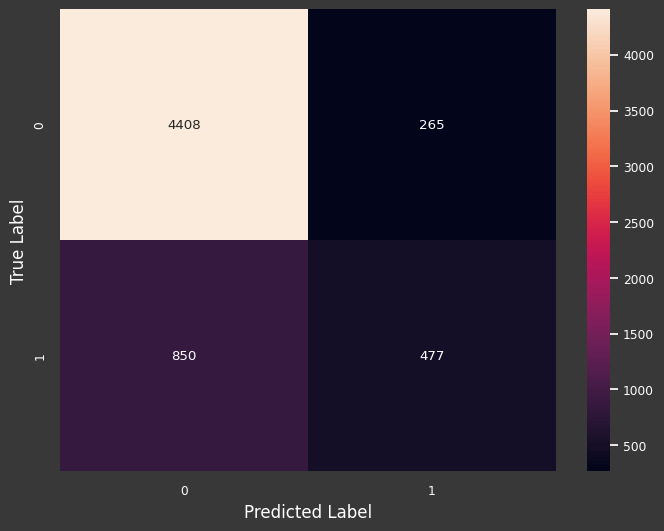

In [99]:
rf_confusion_matrix = metrics.confusion_matrix(Y_test, pred_rf)
sns.heatmap(rf_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [100]:
print(metrics.classification_report(Y_test, pred_rf, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.64      0.36      0.46      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.80      0.81      0.79      6000



ROC_AUC:  0.7571783970865679


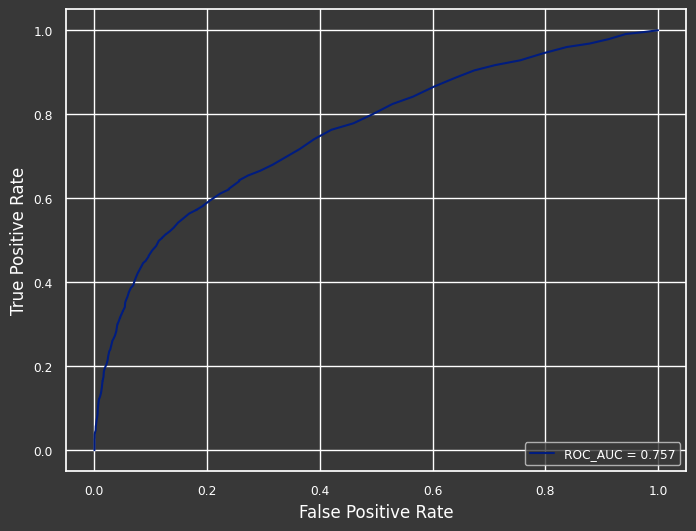

In [101]:
rf_pred_proba = rf_model.predict_proba(X_base_test)[:,1]

rf_roc_auc = metrics.roc_auc_score(Y_test, rf_pred_proba)
print('ROC_AUC: ', rf_roc_auc)

rf_fpr, rf_tpr, thresholds = metrics.roc_curve(Y_test, rf_pred_proba)

plt.plot(rf_fpr,rf_tpr, label = 'ROC_AUC = %0.3f' % rf_roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

**Strengths:** High accuracy and strong performance on class 0.

**Weaknesses:** Struggles with class 1, particularly in recall and F1-score, indicating potential misses in important predictions.

### CATBOOST

In [102]:
categorical_ft_base = ['SEX', 'EDUCATION', 'MARRIAGE']

cat_model = CatBoostClassifier (random_state = 42, eval_metric = 'AUC')
cat_model.fit(X_base_train, Y_train, early_stopping_rounds = 100, eval_set = [(X_base_test,Y_test)], cat_features = categorical_ft_base)
pred_cat = cat_model.predict(X_base_test)

Learning rate set to 0.069474
0:	test: 0.7240948	best: 0.7240948 (0)	total: 88.2ms	remaining: 1m 28s
1:	test: 0.7468602	best: 0.7468602 (1)	total: 123ms	remaining: 1m 1s
2:	test: 0.7527917	best: 0.7527917 (2)	total: 154ms	remaining: 51.2s
3:	test: 0.7581769	best: 0.7581769 (3)	total: 188ms	remaining: 46.8s
4:	test: 0.7606414	best: 0.7606414 (4)	total: 224ms	remaining: 44.5s
5:	test: 0.7621206	best: 0.7621206 (5)	total: 258ms	remaining: 42.8s
6:	test: 0.7637831	best: 0.7637831 (6)	total: 297ms	remaining: 42.1s
7:	test: 0.7631455	best: 0.7637831 (6)	total: 331ms	remaining: 41s
8:	test: 0.7642865	best: 0.7642865 (8)	total: 360ms	remaining: 39.7s
9:	test: 0.7633631	best: 0.7642865 (8)	total: 394ms	remaining: 39s
10:	test: 0.7632833	best: 0.7642865 (8)	total: 426ms	remaining: 38.3s
11:	test: 0.7636472	best: 0.7642865 (8)	total: 460ms	remaining: 37.9s
12:	test: 0.7637678	best: 0.7642865 (8)	total: 496ms	remaining: 37.7s
13:	test: 0.7648081	best: 0.7648081 (13)	total: 527ms	remaining: 37.1s
1

In [128]:
print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_cat))

Test Accuracy:  0.8185


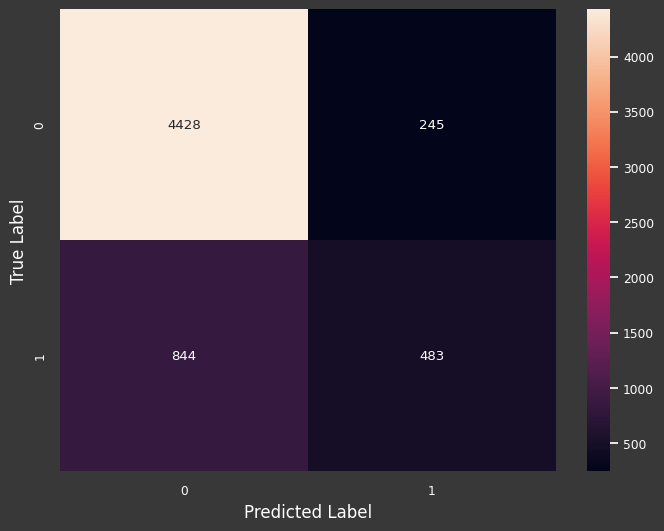

In [103]:

cat_confusion_matrix = metrics.confusion_matrix(Y_test, pred_cat)
sns.heatmap(cat_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [104]:
print(metrics.classification_report(Y_test, pred_cat, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.36      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000



ROC_AUC:  0.7796283899990826


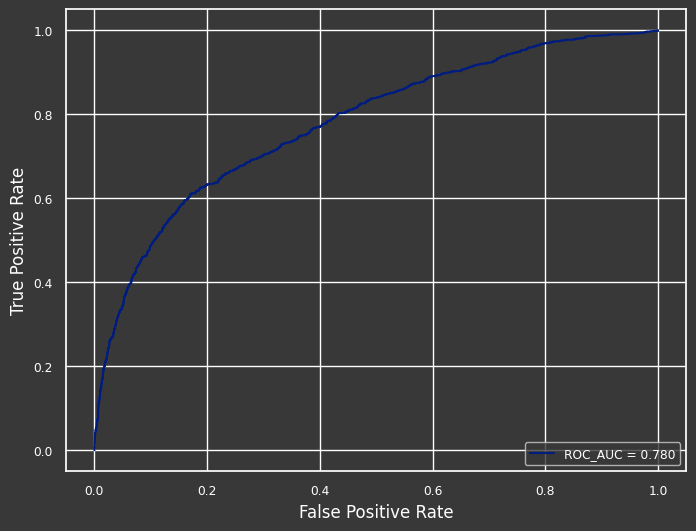

In [105]:
cat_pred_proba = cat_model.predict_proba(X_base_test)[:,1]

cat_roc_auc = metrics.roc_auc_score(Y_test, cat_pred_proba)
print('ROC_AUC: ', cat_roc_auc)

cat_fpr, cat_tpr, thresholds = metrics.roc_curve(Y_test, cat_pred_proba)

plt.plot(cat_fpr,cat_tpr, label = 'ROC_AUC = %0.3f' % cat_roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

**Strengths:**  High precision and recall for class 0, indicating strong performance in identifying the majority class.

**Weaknesses:** Lower recall and F1-score for class 1 suggest the model struggles to identify this class, leading to missed detections.

##  XGBOOST

In [143]:
X_base = load_and_clean_data('default of credit card clients.xls')
Y = X_base['Default']
X = X_base.drop('Default', axis = 1)


In [144]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    random_state=42, stratify=Y)

In [145]:
# Parameter grid for XGBoost
gbm_param_grid = {
    'learning_rate': [0.01, 0.1, 0.5, 0.9],
    'n_estimators': [200],
    'subsample': [0.3, 0.5, 0.9],
    'max_depth': [2, 3, 4, 5],
    'colsample_bytree': [0.1, 0.3, 0.8, 0.9, 0.15]
}

# Initialize the XGBClassifier
gbm = xgb.XGBClassifier()

# Perform grid search
grid_mse = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
                        scoring='accuracy', cv=4, verbose=1)

# Fit the model
grid_mse.fit(X_train, Y_train)

# Print the best parameters and best accuracy score
print("Best parameters found: ", grid_mse.best_params_)
print("Best accuracy found: ", grid_mse.best_score_)

Fitting 4 folds for each of 240 candidates, totalling 960 fits
Best parameters found:  {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}
Best accuracy found:  0.8221666666666667


In [146]:
# Fit the best model obtained from grid search
best_model = grid_mse.best_estimator_
best_model.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [147]:
# Make predictions
pred_xgb = best_model.predict(X_test)

# Calculate accuracy
xgb_accuracy = metrics.accuracy_score(Y_test, pred_xgb)
print('XGBoost Accuracy: {:.3f}'.format(xgb_accuracy))

# Print classification report
print(metrics.classification_report(Y_test, pred_xgb, labels=[0, 1]))

XGBoost Accuracy: 0.819
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4673
           1       0.69      0.33      0.45      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.64      0.67      6000
weighted avg       0.80      0.82      0.79      6000



ROC AUC:  0.7722735314593236


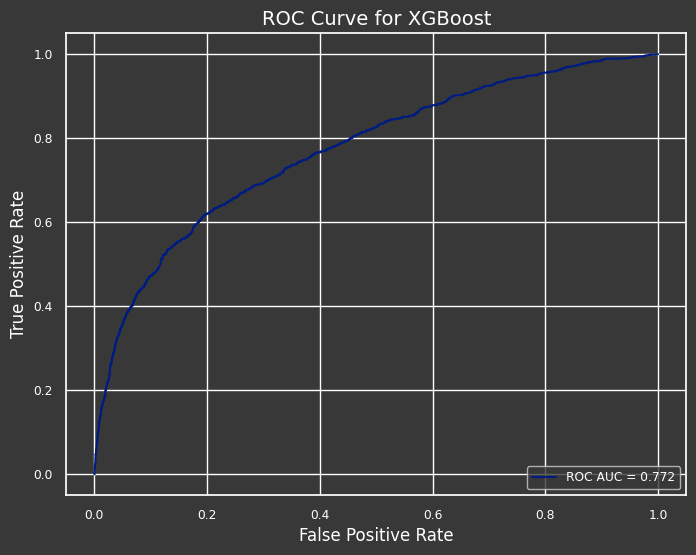

In [148]:
# Calculate predicted probabilities for ROC AUC
xgb_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC
xgb_roc_auc = metrics.roc_auc_score(Y_test, xgb_pred_proba)
print('ROC AUC: ', xgb_roc_auc)

# Compute ROC curve
xgb_fpr, xgb_tpr, thresholds = metrics.roc_curve(Y_test, xgb_pred_proba)

# Plot ROC curve
plt.plot(xgb_fpr, xgb_tpr, label='ROC AUC = %0.3f' % xgb_roc_auc)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve for XGBoost", fontsize=14)
plt.legend(loc="lower right")
plt.show()

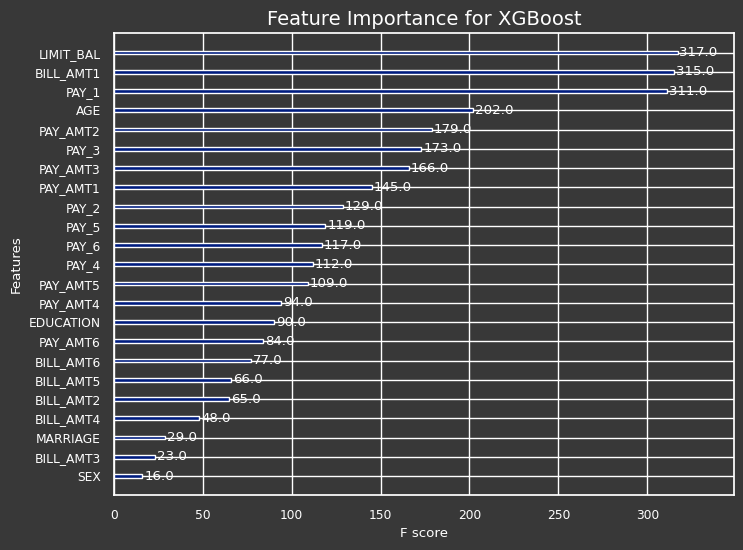

In [149]:
# Plot feature importance
xgb.plot_importance(best_model)
plt.title('Feature Importance for XGBoost', fontsize=14)
plt.show()

In [150]:
# Based on the importance plot, let's define important features
#I'am choosing the top 5 features
important_features = ['PAY_1', 'LIMIT_BAL', 'BILL_AMT1', 'PAY_AMT2', 'AGE']

# Create a new dataset with important features
X_important_train = X_train[important_features]
X_important_test = X_test[important_features]


In [151]:
# Fit the model again using only important features
best_model.fit(X_important_train, Y_train)

# Make predictions with the important features
pred_important_xgb = best_model.predict(X_important_test)

# Calculate accuracy with important features
important_accuracy = metrics.accuracy_score(Y_test, pred_important_xgb)
print('XGBoost Accuracy with Important Features: {:.3f}'.format(important_accuracy))

# Print classification report for important features
print(metrics.classification_report(Y_test, pred_important_xgb, labels=[0, 1]))

XGBoost Accuracy with Important Features: 0.819
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4673
           1       0.69      0.32      0.44      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.64      0.67      6000
weighted avg       0.80      0.82      0.79      6000



## Conclusion: Best Model Selection

Among the three models—**Random Forest**, **CatBoost**, and **XGBoost**—**XGBoost** emerges as the best performer with an accuracy of **81.9%**.

### Key Comparisons:
- **Accuracy**:
  - **XGBoost**: **0.819**
  - **CatBoost**: **0.82**
  - **Random Forest**: **0.814**
  
- **ROC AUC**:
  - **CatBoost**: **0.7796** (best)
  - **XGBoost**: **0.7723**
  - **Random Forest**: **0.7572**

- **Class Performance**:
  - All models excel in precision and recall for class 0, but struggle with class 1.
  - **XGBoost** has the highest precision for class 1 at **0.69**.

## Final Thoughts:
**XGBoost** is preferred for its higher accuracy, while **CatBoost** excels in ROC AUC. Depending on whether accuracy or class discrimination is prioritized, either model can be chosen, with both needing further tuning for better performance on the minority class.
